#### Initailization

In [1]:
desc = {
    "macro_area_ratio": "the ratio of total macros area in the layout",
    "mean_cell_density": "the average cell density in the layout",
    "std_cell_density": "the standard deviation of cell density in the layout",
    "mean_RUDY_long": "the average RUDY long in the layout",
    "mean_RUDY_short": "the average RUDY short in the layout",
    "mean_RUDY_pin_long": "the average RUDY pin long in the layout",
    "mean_eGR_overflow": "the overall mean congestion overflow in early global routing (horizontal and vertical)",
    "mean_GR_overflow": "the overall mean congestion overflow in global routing (horizontal and vertical)",
}

In [2]:
feat_func_list = []

In [3]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [ ]:
api_key = "<your_api_key>"

def encode_image(features):
    features_b64 = []
    for image in features:
        buff = BytesIO()
        image.save(buff, format="PNG")
        buff.seek(0)
        image_b64 = base64.b64encode(buff.read()).decode()
        features_b64.append(image_b64)
    return features_b64

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [5]:
import models
device = "cuda:4"
opt = {'task': 'drc_routenet', 'save_path': 'work_dir/drc_routenet/', 'pretrained': '/home/felixchaotw/CircuitNet/model/DRC.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/DRC', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'DRCDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'RouteNet', 'in_channels': 9, 'out_channels': 1, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["RouteNet"](**opt)
model.init_weights(**opt)
model.to(device)

/home/felixchaotw/mllm-physical-design/DRV/feat_extract/models/routenet.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(pretrained, map_location='c

RouteNet(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): Batc

In [6]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [7]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq



def get_drc_violations(image, threshold=0.1):
    """
    Get DRC violations from the image based on a threshold.
    """
    violations = np.where(image > threshold, 1, 0).sum()
    return violations


file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/DRC/feature/zero-riscy-a/7228-zero-riscy-a-1-c2-u0.9-m2-p4-f0.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/DRC/label/zero-riscy-a/7228-zero-riscy-a-1-c2-u0.9-m2-p4-f0.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    image_features.append(image)
    image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
drv_nums = get_drc_violations(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(drv_nums)

11095


In [8]:
base64_images = encode_image(image_inferences)

In [9]:
def macro_area_ratio(images):
    image = images[0]
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    centroids = []
    total_macros_area = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_macros_area += w * h
    
    return {"macro_area_ratio": total_macros_area / total_image_area}


def mean_macro_edge_length(images):
    image = images[0]
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    centroids = []
    total_edge_length = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_edge_length += 2 * (w + h)
        
        
    return {"mean_macro_edge_length": (total_edge_length / num_macros) * tiles_size}


def mean_macro_neighbor_distance(images):
    image = images[0]
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    centroids = []
    total_macros_area = 0
    total_edge_length = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_macros_area += w * h
        total_edge_length += 2 * (w + h)
        centroid_x = x + w / 2
        centroid_y = y + h / 2
        centroids.append((centroid_x, centroid_y))
    
    neighbor_distances = []
    for i, (x1, y1) in enumerate(centroids):
        min_distance = float("inf")  
        for j, (x2, y2) in enumerate(centroids):
            if i != j: 
                distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                if distance < min_distance:
                    min_distance = distance
        neighbor_distances.append(min_distance)
    

    if neighbor_distances and num_macros > 1:
        mean_neighbor_distance = sum(neighbor_distances) / len(neighbor_distances)
    else:
        mean_neighbor_distance = 0.0
    
    
    return {"mean_macro_neighbor_distance": float(mean_neighbor_distance * tiles_size)}


def mean_cell_density(images):
    image = images[1]
    total_area = image.shape[0] * image.shape[1]
    mean_density = np.mean(image)
    
    return {"mean_cell_density": mean_density}

def std_cell_density(images):
    image = images[1]
    total_area = image.shape[0] * image.shape[1]
    std_density = np.std(image)
    
    return {"std_cell_density": std_density}


def mean_RUDY_long(images):
    image = images[2]
    total_area = image.shape[0] * image.shape[1]
    mean_rudy_long = np.mean(image)
    
    return {"mean_RUDY_long": mean_rudy_long}

def mean_RUDY_short(images):
    image = images[3]
    total_area = image.shape[0] * image.shape[1]
    mean_rudy_short = np.mean(image)
    
    return {"mean_RUDY_short": mean_rudy_short}

def mean_RUDY_pin_long(images):
    image = images[4]
    total_area = image.shape[0] * image.shape[1]
    mean_rudy_pin_long = np.mean(image)
    
    return {"mean_RUDY_pin_long": mean_rudy_pin_long}

def mean_eGR_overflow(images):
    image_h = images[5]
    image_v = images[6]
    image = image_h + image_v
    total_area = image.shape[0] * image.shape[1]
    mean_eGR_overflow = np.mean(image)
    
    return {"mean_eGR_overflow": mean_eGR_overflow}

def mean_GR_overflow(images):
    image_h = images[7]
    image_v = images[8]
    image = image_h + image_v
    total_area = image.shape[0] * image.shape[1]
    mean_GR_overflow = np.mean(image)
    
    return {"mean_GR_overflow": mean_GR_overflow}

In [10]:
feat_func_list = [
    macro_area_ratio,
    mean_cell_density,
    std_cell_density,
    mean_RUDY_long,
    mean_RUDY_short,
    mean_RUDY_pin_long,
    mean_eGR_overflow,
    mean_GR_overflow
]

In [11]:
def get_all_features(images):
    final_features = {}
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

#### Fitness Scoring

In [411]:
get_all_features(image_features)

{'max_congestion_ripple': 90.0,
 'macro_interference_zone': 225078.75,
 'macro_compactness_index': 0.010917102899855733,
 'cell_density_variance_gradient': np.float64(0.002547227626207137),
 'mean_macro_proximity': np.float64(0.3278047219932913),
 'congestion_gradient': np.float64(0.38317922651810027),
 'cell_density_anisotropy': np.float64(12.659571833871114),
 'mean_eGR_local_variability': np.float64(2.0692643376092803e-05),
 'diagonal_cell_density_gradient': np.float64(0.055367297852235625),
 'mean_cell_density_fluctuation': np.float64(0.40313851594176975),
 'macro_transition_band': np.float64(842.7158679246136),
 'cell_density_skewness': np.float64(1.5351419454983046),
 'cell_density_skewness_gradient': np.float64(10.836382926838187),
 'macro_interaction_perimeter': 1730.2712259292603,
 'cell_density_fluctuation_balance': np.float64(25.466824632629187),
 'congestion_pressure_fluctuation': np.float64(28.412934256099604),
 'congestion_variability_throughout_hierarchy': np.float64(1.5

In [412]:
import pandas as pd
from tqdm import tqdm
import os
import torch
import multiprocessing


def single_extractor(design):
    feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/DRC/feature/{design}/" 
    label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/DRC/label/{design}/"

    labels = []
    ids = []

    for filename in tqdm(os.listdir(label_path)):
            file_path = os.path.join(label_path, filename)
            label_image = np.load(file_path).squeeze()
            label = get_drc_violations(label_image)
            ids.append(filename)
            labels.append(label)
            
    df = pd.DataFrame({"id": ids,})

    for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value
        
    df['label'] = labels
    return df


def dataset_setting(designs):
    pool = multiprocessing.Pool()
    df_list = pool.map(single_extractor, designs)
    return pd.concat(df_list)

In [413]:
train_df = dataset_setting(train_design)
test_df_a = dataset_setting(test_design_a)
test_df_b = dataset_setting(test_design_b)

100%|██████████| 1122/1122 [01:48<00:00, 10.33it/s]


In [414]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_a.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

In [415]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

x = train_df.drop(columns=["id", "label"])
y = train_df["label"]
regressor = RandomForestRegressor(random_state=42, max_depth=50, max_features='sqrt', min_samples_leaf=1, n_estimators=300)
regressor.fit(x, y)

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=300,
                      random_state=42)

Text(0, 0.5, 'Feature')

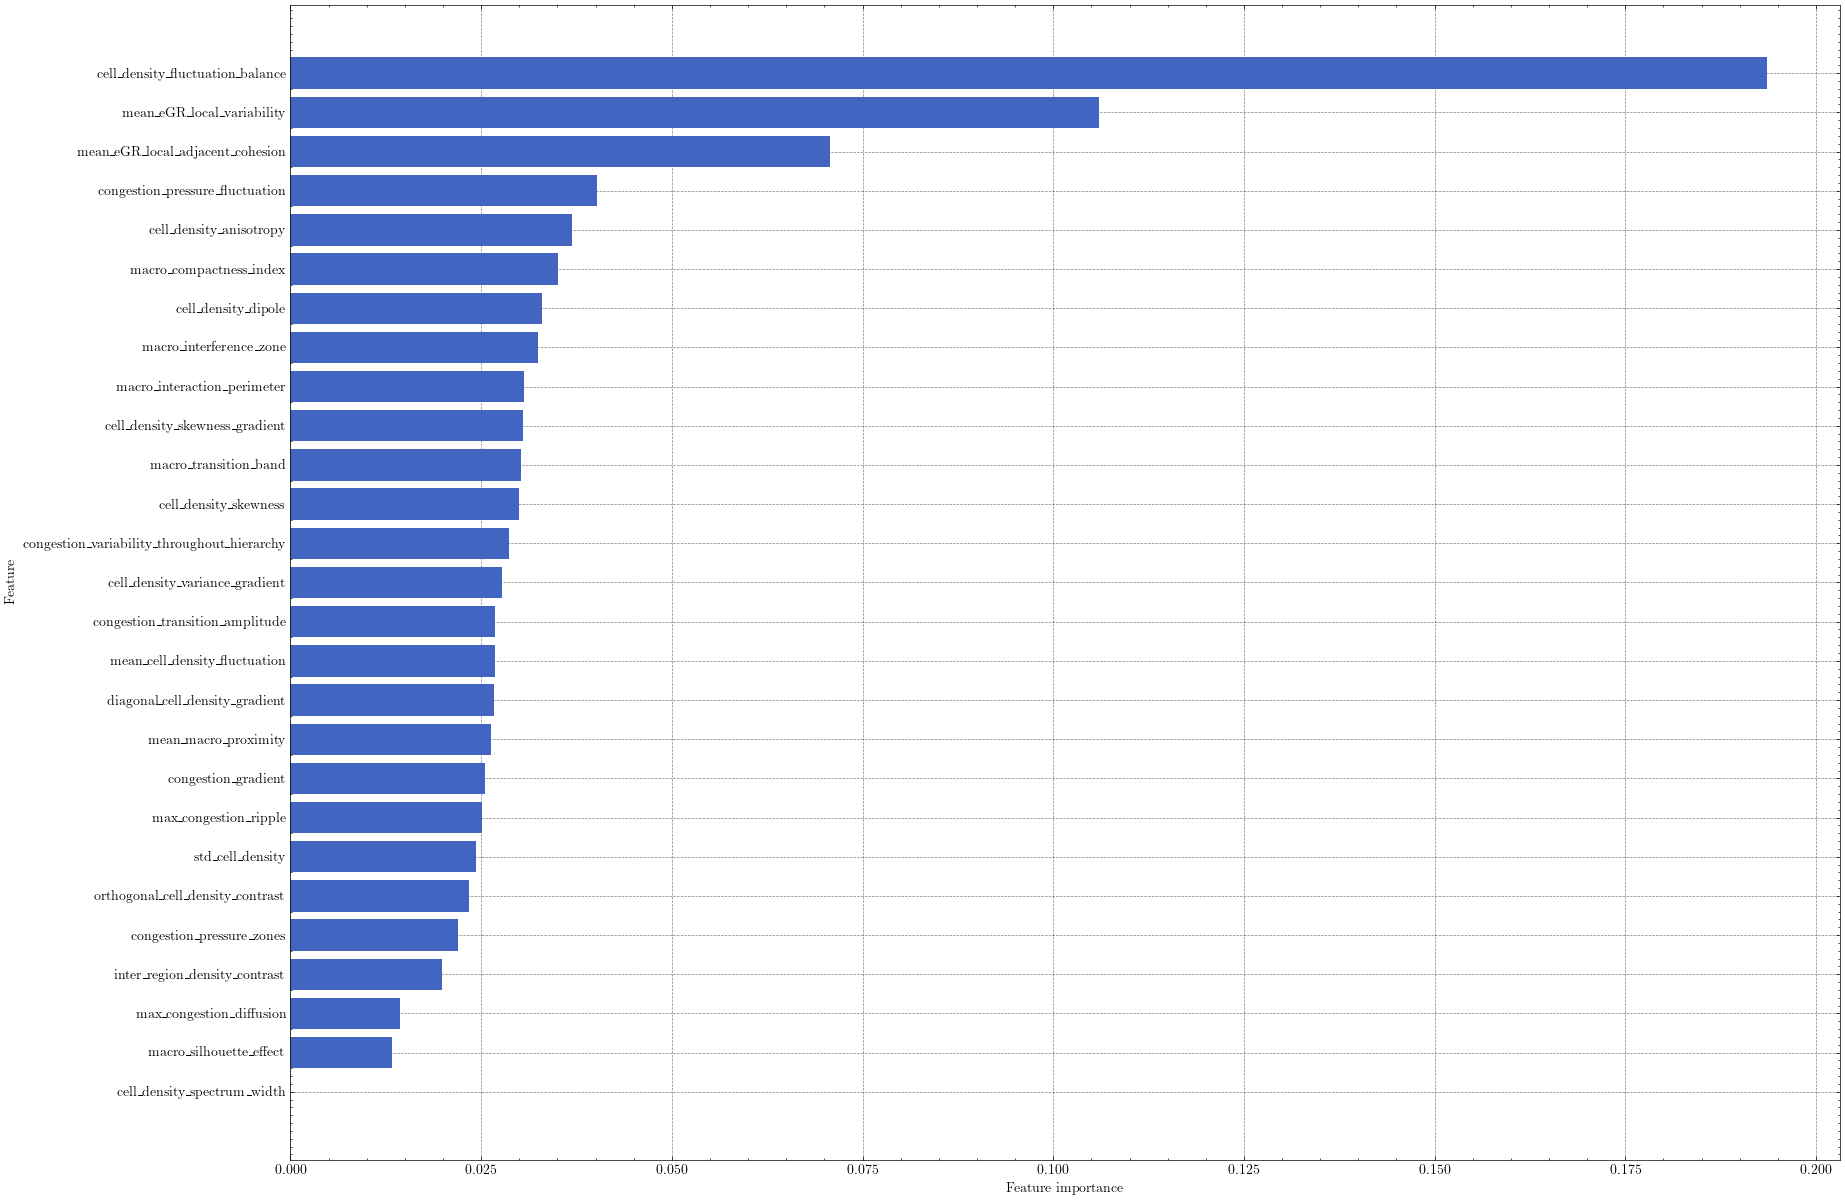

In [397]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [416]:
y_hat_a = regressor.predict(test_df_a.drop(columns=["id", "label"]))
y_hat_b = regressor.predict(test_df_b.drop(columns=["id", "label"]))
test_df_a["prediction"] = y_hat_a
test_df_b["prediction"] = y_hat_b

In [417]:
test_df_a = test_df_a.drop_duplicates(subset=["label"])
test_df_b = test_df_b.drop_duplicates(subset=["label"])

In [418]:
from scipy import stats
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
plt.style.use(['science','grid','retro'])

def replaceWithRank(arr):
    n = len(arr)
    res = [0] * n
    pq = []
    for i in range(n):
        heapq.heappush(pq, (arr[i], i))

    rank = 0
    lastNum = float('inf')

    while pq:
        curr, index = heapq.heappop(pq)

        if lastNum == float('inf') or curr != lastNum:
            rank += 1
            
        res[index] = rank - 1
        lastNum = curr

    return res

def evalute_corr(drc_set, predicted, corr_metrics):
    x = np.array(list(drc_set.values()))
    x_label = list(drc_set.keys())
    y = np.array([predicted[id] for id in x_label])
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evaluate_design(df):
    drc_set = dict(zip(df["id"], df["label"]))
    drc_set = dict(sorted(drc_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(drc_set, predicted, corr_metrics)
    x = list(drc_set.keys())[::10]
    x = [name.split("-")[0] for name in x]
    x_label = list(range(0,len(x)))
    y = [predicted[file_path] for file_path in drc_set.keys()][::10]
    y_label = replaceWithRank(y)
    plt.figure(figsize=(10,5))
    plt.plot(x, y_label, linewidth="2", marker="o")
    plt.plot(x, x_label, linewidth="2", marker="o")
    plt.xticks(ticks=x_label, labels=x, rotation=90)
    plt.xlabel("Images")
    plt.ylabel("Rank Order")
    plt.title("DRC Violations Rank Order")
    plt.legend(["Predicted", "Ground Truth"])
    return results

#### Baseline

{'PLCC': PearsonRResult(statistic=np.float64(0.5732222320571638), pvalue=np.float64(3.231212824137718e-30)),
 'SRCC': SignificanceResult(statistic=np.float64(0.5658629472346769), pvalue=np.float64(2.503967726909684e-29)),
 'KRCC': SignificanceResult(statistic=np.float64(0.39007092198581567), pvalue=np.float64(3.980137551081899e-26))}

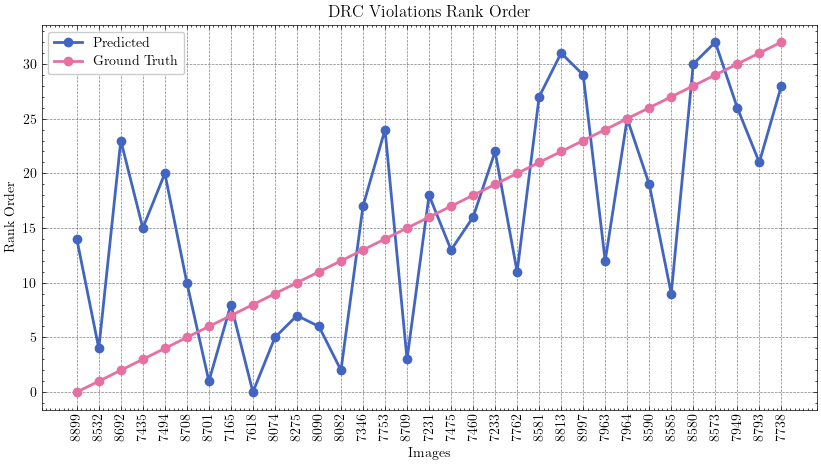

In [23]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.28043018098160144), pvalue=np.float64(1.0396576067474906e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1470939595012695), pvalue=np.float64(0.005975943790293075)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09877933651585905), pvalue=np.float64(0.00595631208923143))}

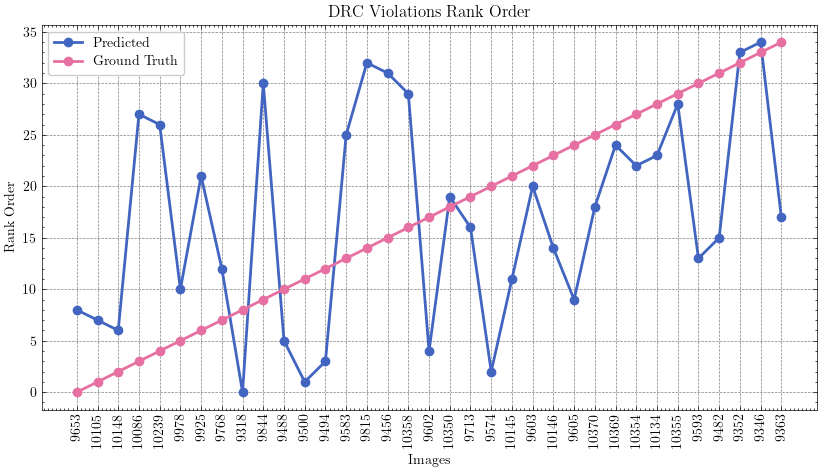

In [24]:
evaluate_design(test_df_b)

#### Stage 1.

{'PLCC': PearsonRResult(statistic=np.float64(0.60553799633876), pvalue=np.float64(2.117930978152774e-34)),
 'SRCC': SignificanceResult(statistic=np.float64(0.5843641606192226), pvalue=np.float64(1.3171591094758183e-31)),
 'KRCC': SignificanceResult(statistic=np.float64(0.40370268029842504), pvalue=np.float64(7.227332418290779e-28))}

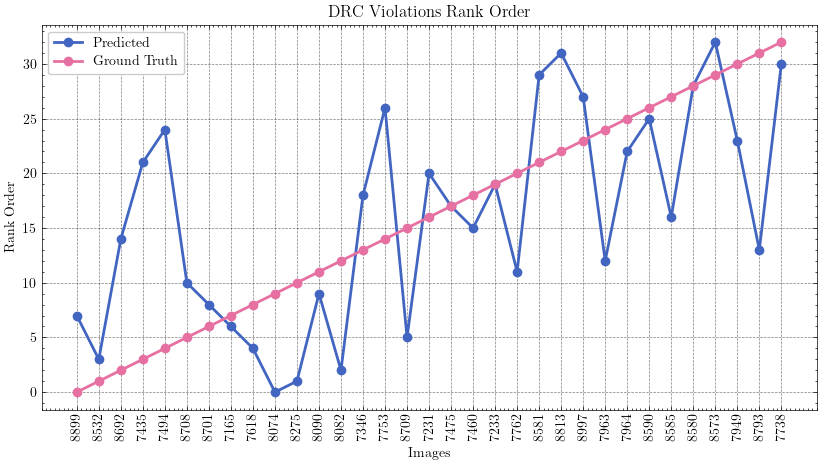

In [66]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.35226018314924346), pvalue=np.float64(1.326014886824435e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.23686841553957122), pvalue=np.float64(7.949176878356976e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.15852456722023234), pvalue=np.float64(1.0172561422133242e-05))}

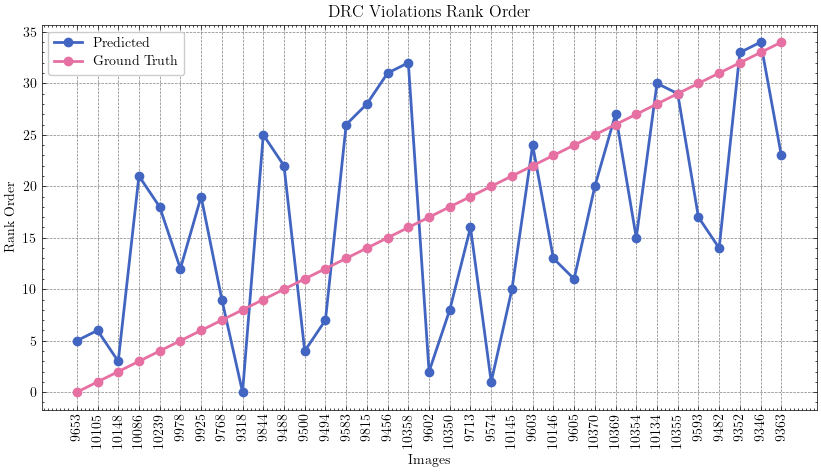

In [67]:
evaluate_design(test_df_b)

#### Stage 2.

{'PLCC': PearsonRResult(statistic=np.float64(0.627531341703863), pvalue=np.float64(1.5615839710800932e-37)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6446398622910804), pvalue=np.float64(3.782725821586157e-40)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4439716312056738), pvalue=np.float64(2.3582061463315013e-33))}

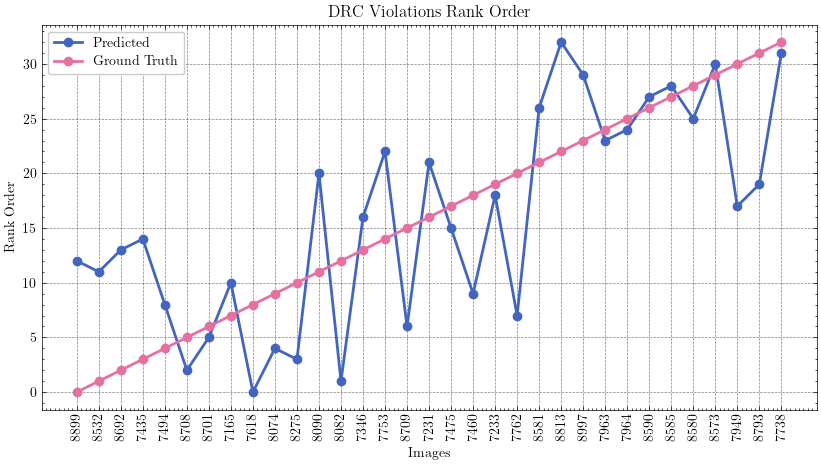

In [124]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.3596579902762391), pvalue=np.float64(4.579078696595902e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.22377433513950526), pvalue=np.float64(2.52020525621715e-05)),
 'KRCC': SignificanceResult(statistic=np.float64(0.149575586937347), pvalue=np.float64(3.120893150396134e-05))}

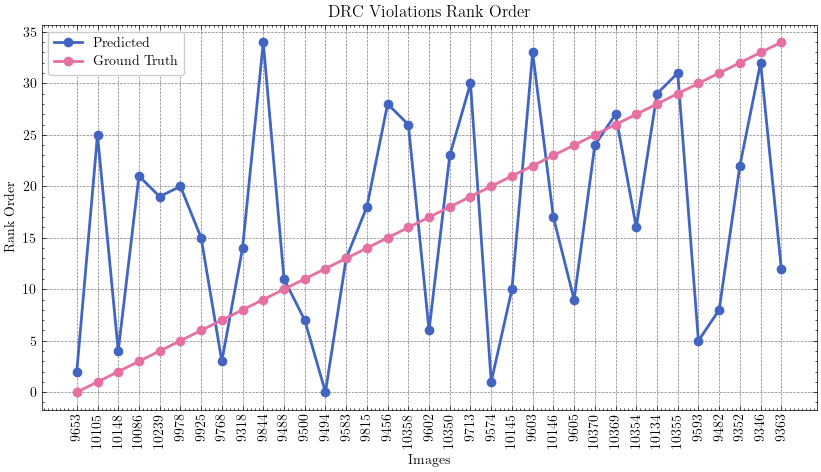

In [125]:
evaluate_design(test_df_b)

#### Stage 3.

{'PLCC': PearsonRResult(statistic=np.float64(0.6724970760921081), pvalue=np.float64(8.742025527916456e-45)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6845627599886134), pvalue=np.float64(5.921139864802112e-47)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4875932578060238), pvalue=np.float64(7.070766024626684e-40))}

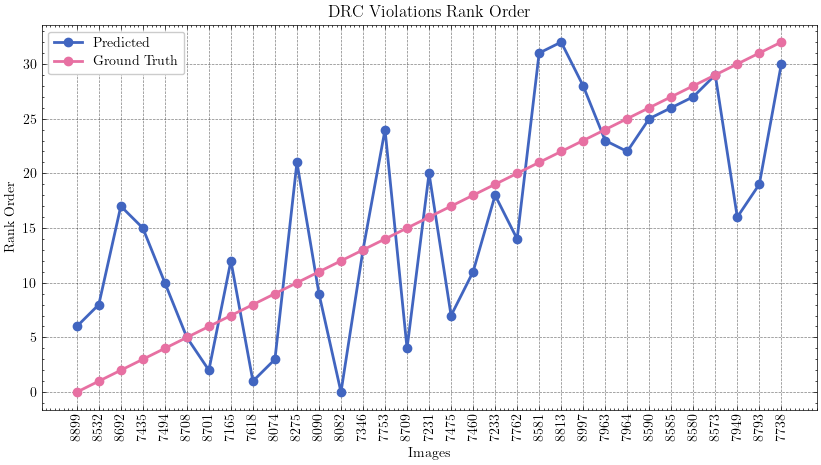

In [172]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.27446939179731733), pvalue=np.float64(1.9717950929865997e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1211860977845305), pvalue=np.float64(0.023765304379928152)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08715094902116666), pvalue=np.float64(0.015246792108421604))}

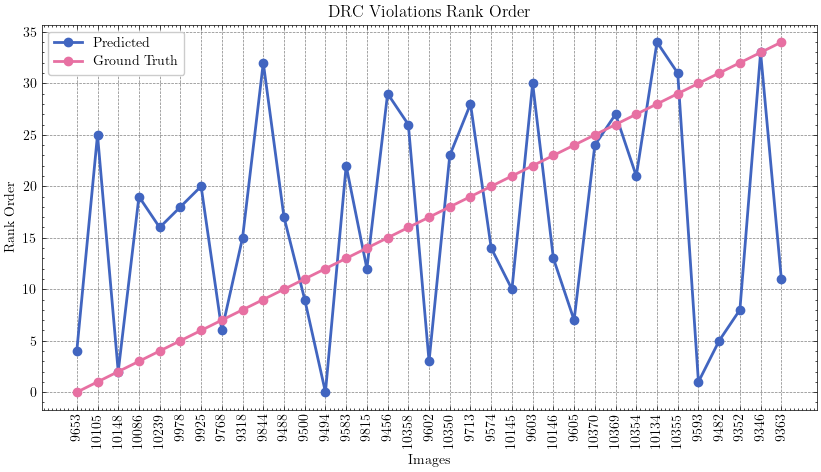

In [173]:
evaluate_design(test_df_b)

#### Stage 4.

{'PLCC': PearsonRResult(statistic=np.float64(0.6487441983200346), pvalue=np.float64(8.417809178698993e-41)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6747909029968553), pvalue=np.float64(3.4447710117023117e-45)),
 'KRCC': SignificanceResult(statistic=np.float64(0.47731417518651564), pvalue=np.float64(2.760178811077672e-38))}

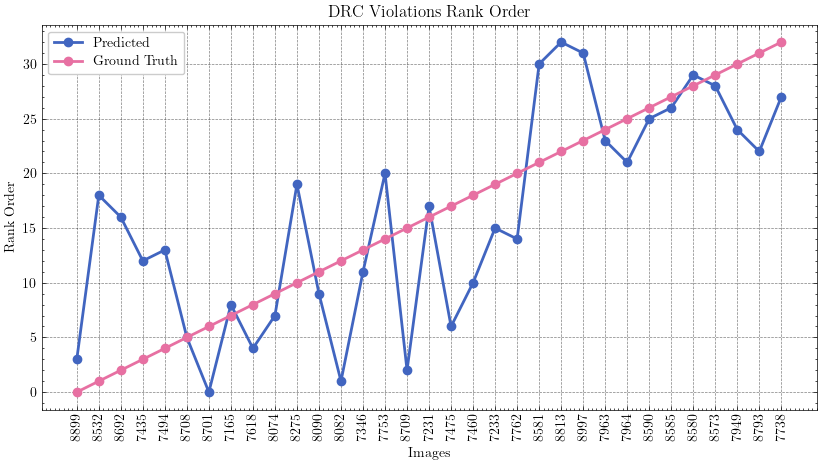

In [220]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.4001672289022802), pvalue=np.float64(8.163509816989816e-15)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3380334266613173), pvalue=np.float64(9.492103565428257e-11)),
 'KRCC': SignificanceResult(statistic=np.float64(0.22803007718042997), pvalue=np.float64(2.1695772912423854e-10))}

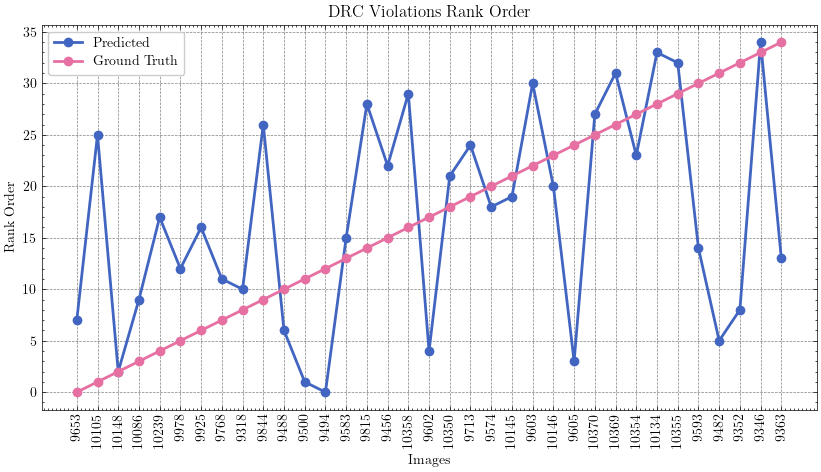

In [221]:
evaluate_design(test_df_b)

#### Stage 5.

{'PLCC': PearsonRResult(statistic=np.float64(0.6669647191838489), pvalue=np.float64(7.984963471867103e-44)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6972487434144565), pvalue=np.float64(2.372805309725795e-49)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4937828129317492), pvalue=np.float64(7.498771412870911e-41))}

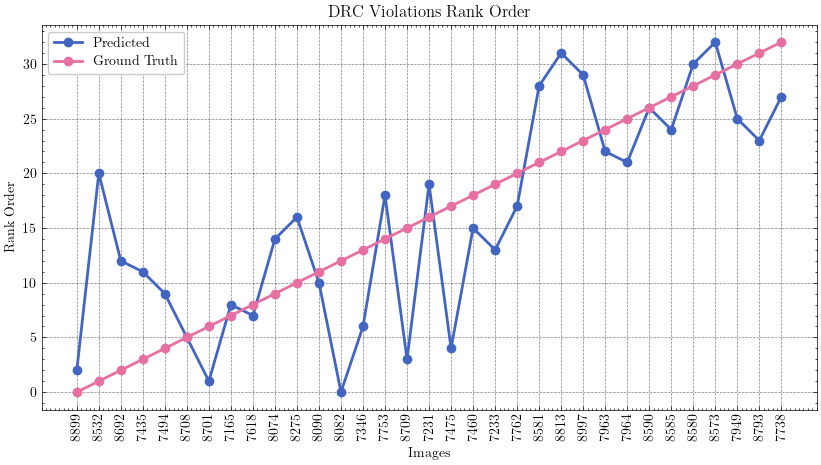

In [44]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.37875415350110414), pvalue=np.float64(2.58452339035543e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3083073989387923), pvalue=np.float64(4.243319503616826e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.20330421101272667), pvalue=np.float64(1.5105144148535686e-08))}

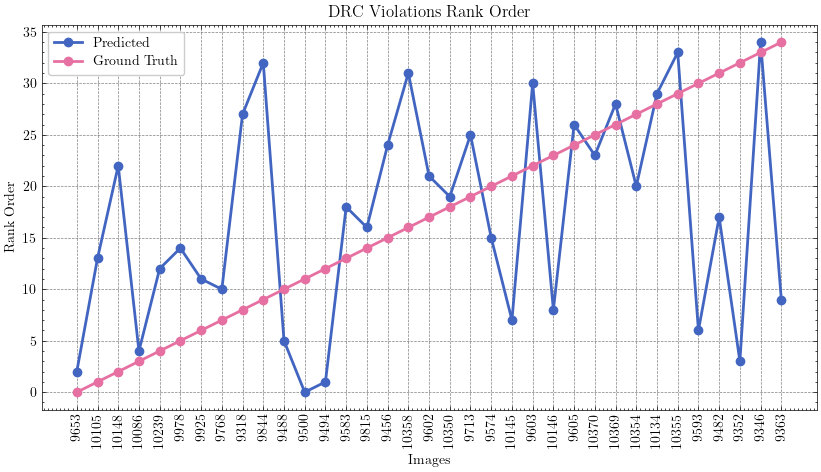

In [45]:
evaluate_design(test_df_b)

#### Stage 6

{'PLCC': PearsonRResult(statistic=np.float64(0.7027188065041559), pvalue=np.float64(2.0065604327154029e-50)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7085108887384389), pvalue=np.float64(1.3784907519593767e-51)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5041724233213596), pvalue=np.float64(1.629032098350938e-42))}

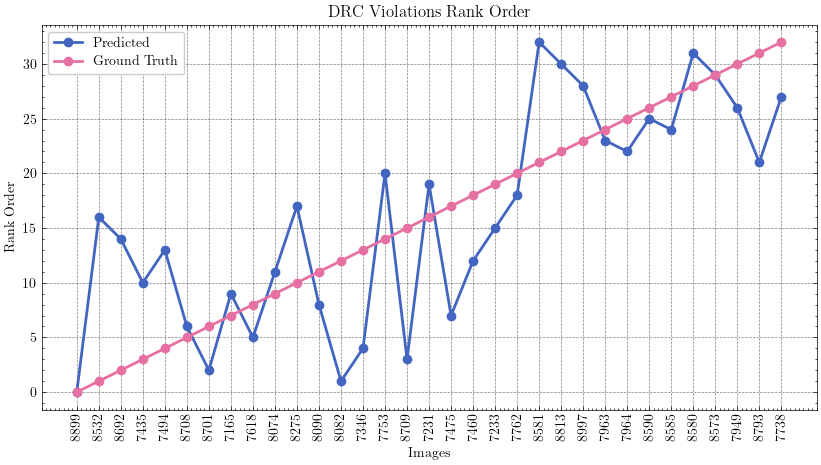

In [79]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.3556170026773753), pvalue=np.float64(8.212982078992907e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.2897998041848994), pvalue=np.float64(3.685863995841901e-08)),
 'KRCC': SignificanceResult(statistic=np.float64(0.1939480265930096), pvalue=np.float64(6.670507369697468e-08))}

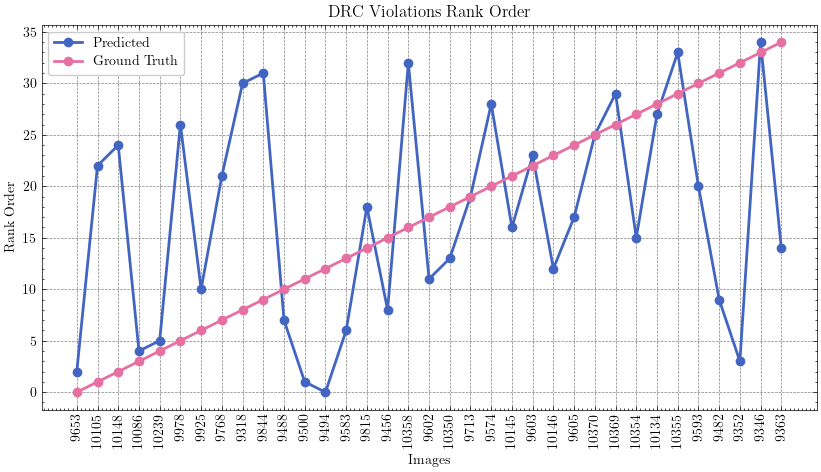

In [80]:
evaluate_design(test_df_b)

#### Stage 7

{'PLCC': PearsonRResult(statistic=np.float64(0.720047310842128), pvalue=np.float64(5.440053313854611e-54)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7090184482869447), pvalue=np.float64(1.086736117480168e-51)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5039513677811551), pvalue=np.float64(1.7687669905860877e-42))}

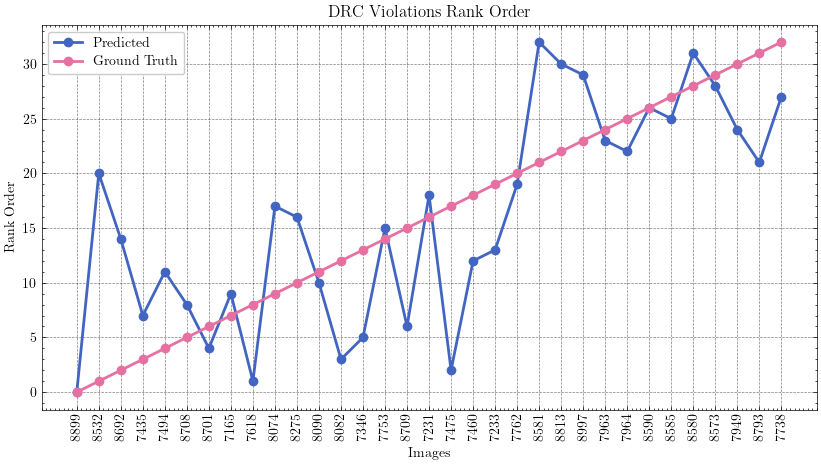

In [118]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.38574044155350645), pvalue=np.float64(8.605462860474595e-14)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3751446118678685), pvalue=np.float64(4.515454834577631e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.255092914637782), pvalue=np.float64(1.2268313869626179e-12))}

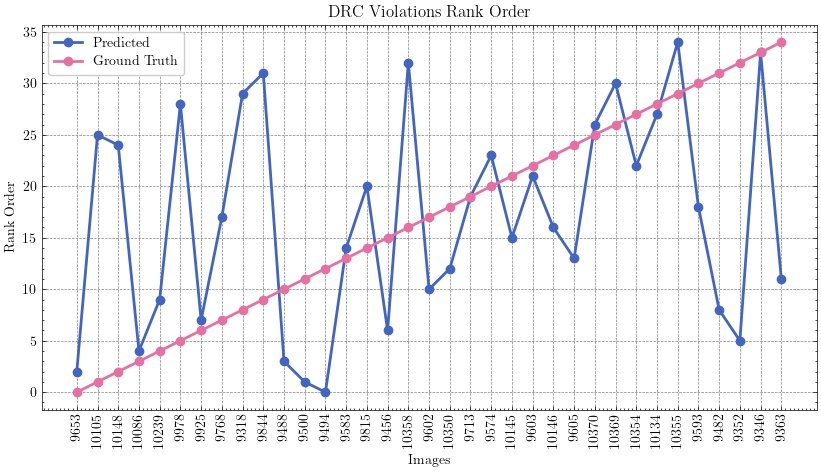

In [119]:
evaluate_design(test_df_b)

#### Stage 8

{'PLCC': PearsonRResult(statistic=np.float64(0.732242201906754), pvalue=np.float64(1.1465897874680717e-56)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7270668651269024), pvalue=np.float64(1.6325262487626768e-55)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5203094777562863), pvalue=np.float64(3.638643070629179e-45))}

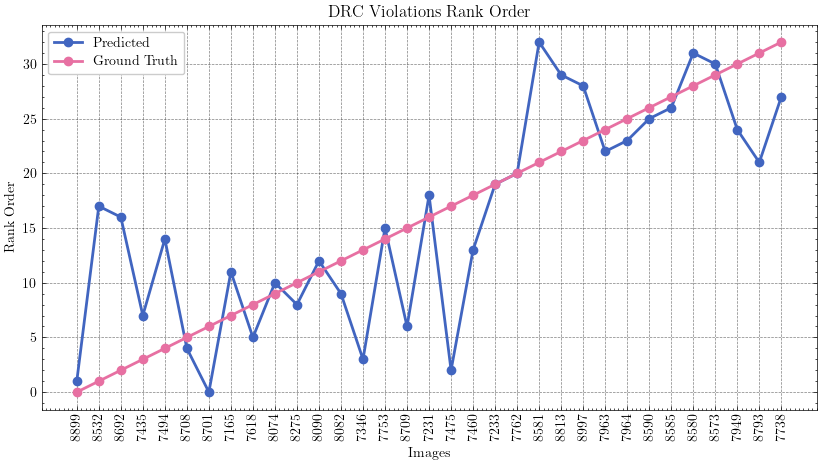

In [152]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.3792386083374586), pvalue=np.float64(2.396781120627299e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4094314699912044), pvalue=np.float64(1.6915460013900449e-15)),
 'KRCC': SignificanceResult(statistic=np.float64(0.2797707774354897), pvalue=np.float64(6.732861526102448e-15))}

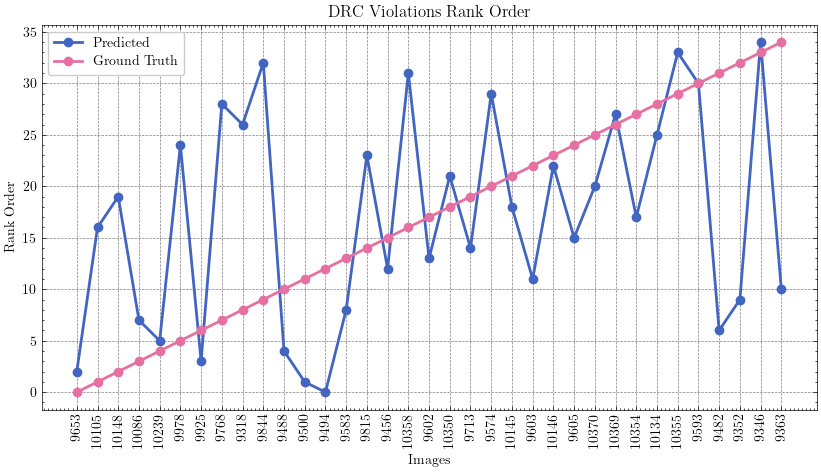

In [153]:
evaluate_design(test_df_b)

#### Stage 9

{'PLCC': PearsonRResult(statistic=np.float64(0.726559521390013), pvalue=np.float64(2.1110904726054787e-55)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7141364517079628), pvalue=np.float64(9.596644800929237e-53)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5089619600257899), pvalue=np.float64(2.7147688250428386e-43))}

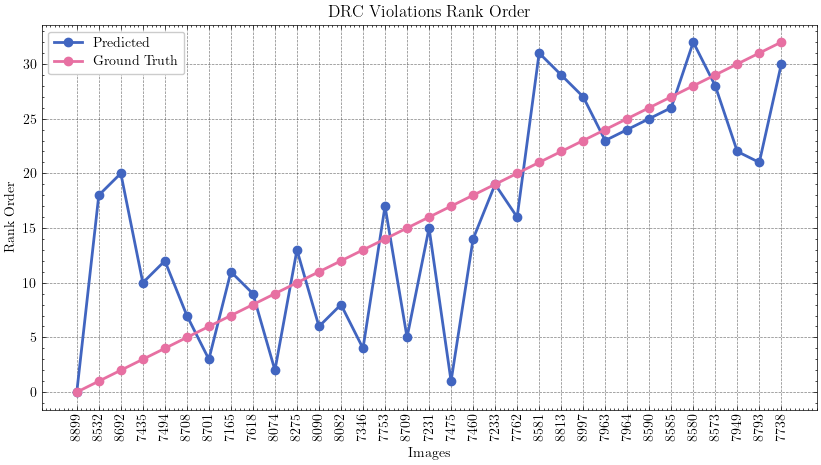

In [194]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.38212602695742354), pvalue=np.float64(1.525073565411756e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.3958565039838018), pvalue=np.float64(1.670193459474122e-14)),
 'KRCC': SignificanceResult(statistic=np.float64(0.2697098186188939), pvalue=np.float64(5.95645329798737e-14))}

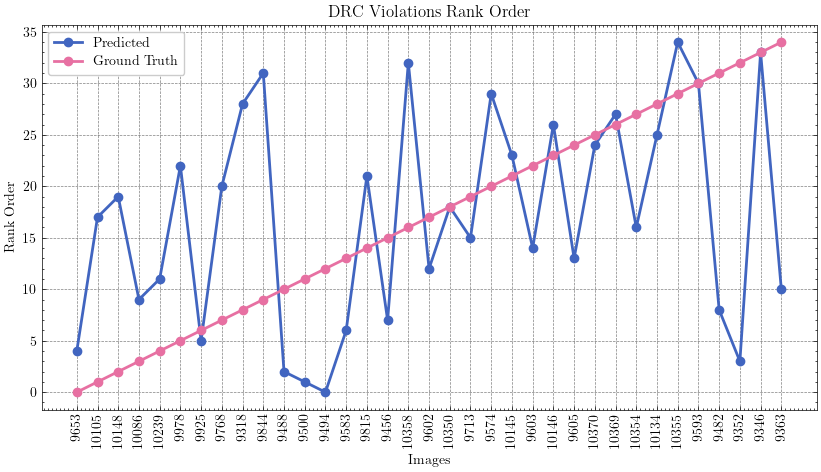

In [195]:
evaluate_design(test_df_b)

#### Stage 10

{'PLCC': PearsonRResult(statistic=np.float64(0.7436302645534303), pvalue=np.float64(2.65415838623873e-59)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7271573576516689), pvalue=np.float64(1.5592645945443499e-55)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5273832550428296), pvalue=np.float64(2.3593763351689514e-46))}

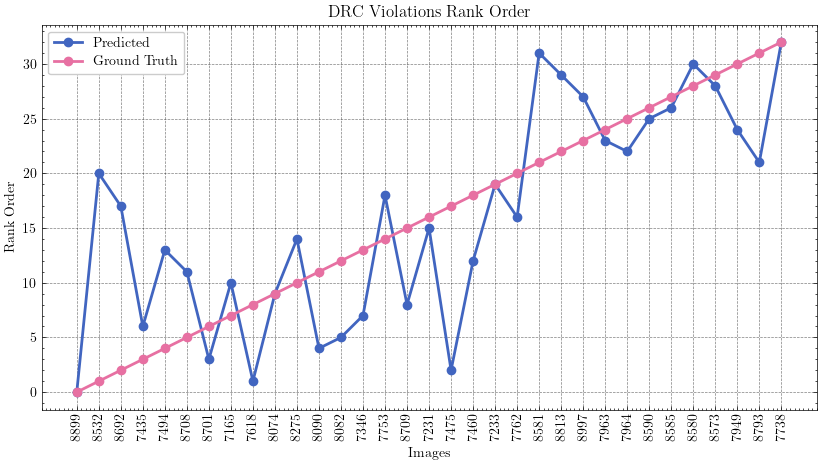

In [243]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.3669503590608475), pvalue=np.float64(1.5622746494451066e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.40392663782117155), pvalue=np.float64(4.3354877421160154e-15)),
 'KRCC': SignificanceResult(statistic=np.float64(0.27256842367710327), pvalue=np.float64(3.2286024983408996e-14))}

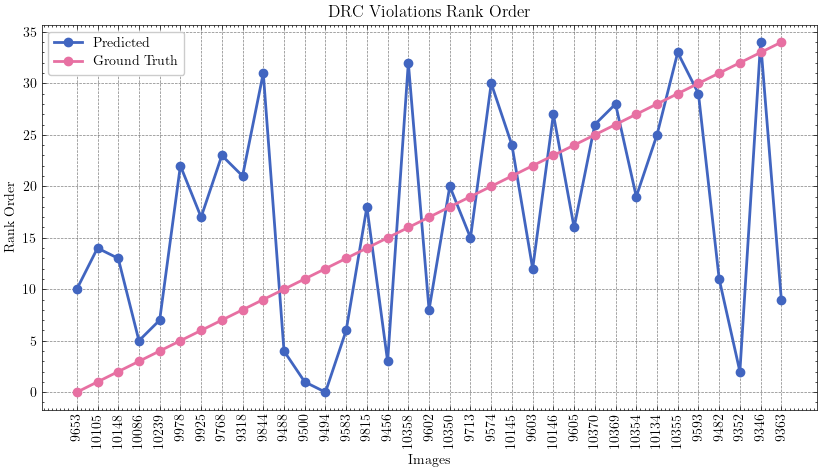

In [244]:
evaluate_design(test_df_b)

#### Stage 11

{'PLCC': PearsonRResult(statistic=np.float64(0.7474587415848148), pvalue=np.float64(3.2084250319490046e-60)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7406951729250372), pvalue=np.float64(1.3074407597768845e-58)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5358202081606337), pvalue=np.float64(8.608192493951882e-48))}

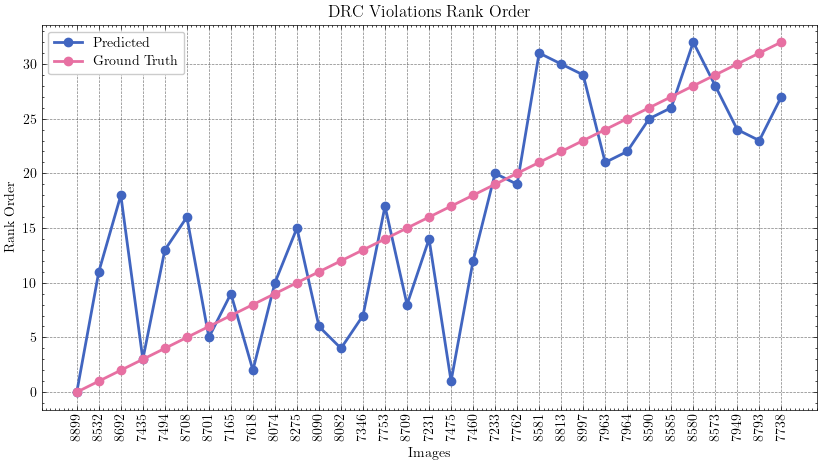

In [279]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.4180869813643676), pvalue=np.float64(3.7167182151102826e-16)),
 'SRCC': SignificanceResult(statistic=np.float64(0.5012099987841641), pvalue=np.float64(1.557987785082322e-23)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3407863791447216), pvalue=np.float64(2.3505771662269077e-21))}

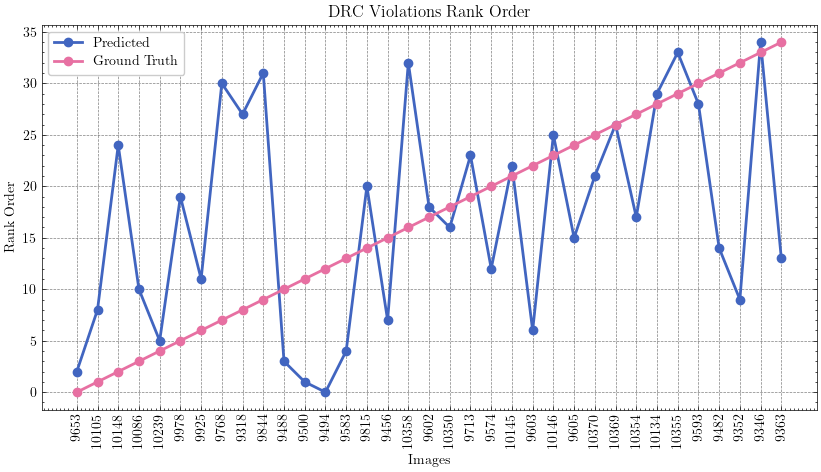

In [280]:
evaluate_design(test_df_b)

#### Stage 12

{'PLCC': PearsonRResult(statistic=np.float64(0.760409483895913), pvalue=np.float64(1.8851015370197368e-63)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7835101582867862), pvalue=np.float64(9.327251777641147e-70)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5832734641245281), pvalue=np.float64(2.6689691288370033e-56))}

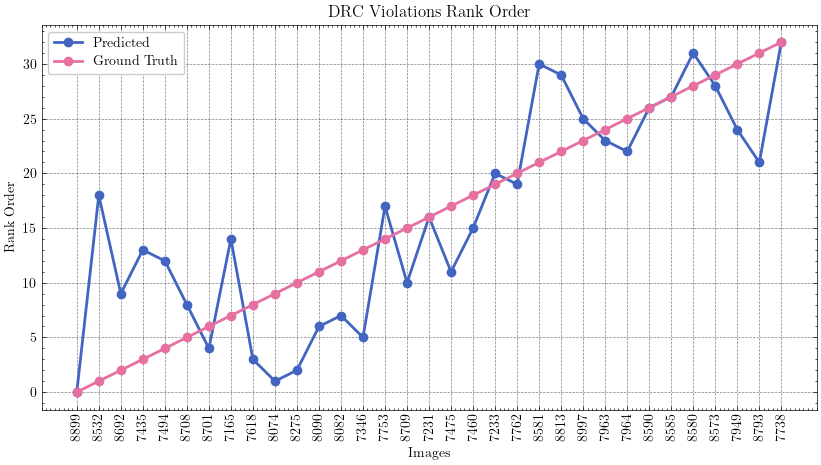

In [339]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6720585401669025), pvalue=np.float64(4.55458713879749e-47)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6482038976940918), pvalue=np.float64(7.411568694951163e-43)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4619104799131514), pvalue=np.float64(7.514638859407689e-38))}

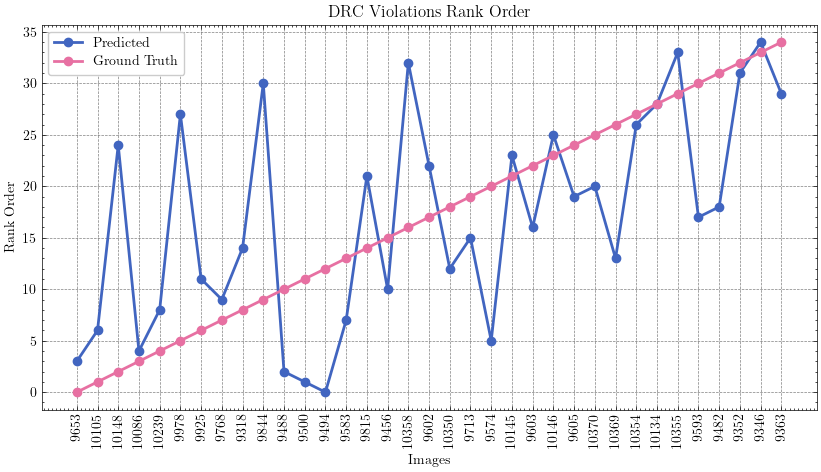

In [340]:
evaluate_design(test_df_b)

#### Stage 13

{'PLCC': PearsonRResult(statistic=np.float64(0.7601515862785689), pvalue=np.float64(2.1961945946446238e-63)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7909632695516863), pvalue=np.float64(5.854020119353377e-72)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5876577323385834), pvalue=np.float64(4.0189941823202707e-57))}

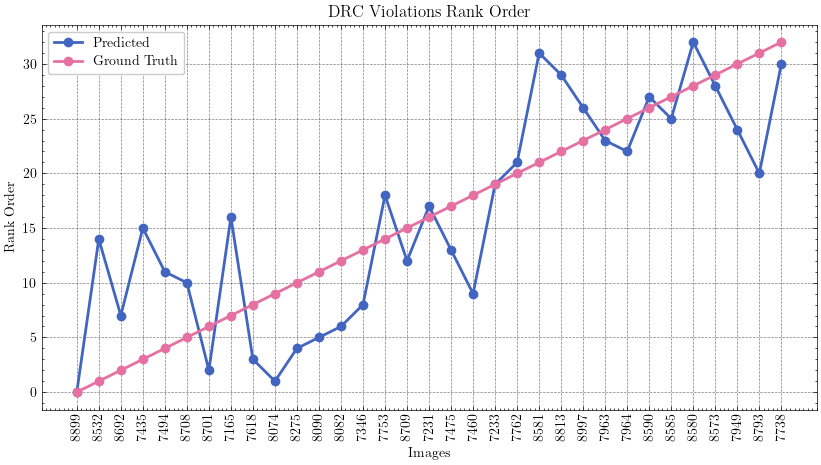

In [398]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6701169983794193), pvalue=np.float64(1.0372940606046391e-46)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6965219404285949), pvalue=np.float64(8.121788448692504e-52)),
 'KRCC': SignificanceResult(statistic=np.float64(0.503229653184935), pvalue=np.float64(1.3359064166595384e-44))}

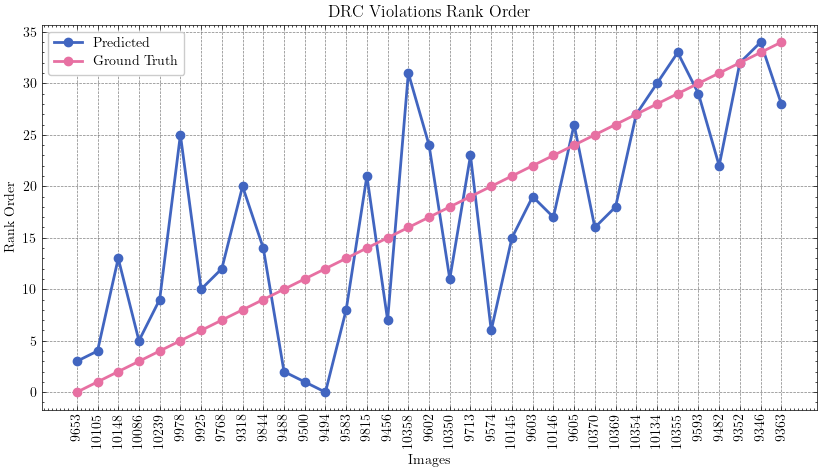

In [399]:
evaluate_design(test_df_b)

#### Genetic Algorithm

In [406]:
feat_importances = feature_importance[sorted_idx][-20:]
feat_pool = list(x.columns[sorted_idx])[-20:]

In [407]:
def forget_curve(t, S=20):
    return np.exp(-t/S)

In [408]:
feat_importances = {feat: imp for feat, imp in zip(feat_pool, feat_importances)}
feat_pool = {feat: desc[feat] for feat in feat_pool}
n = len(feat_pool)
feat_importances = {feat: forget_curve(n - i, n) for i, feat in enumerate(feat_importances.keys())}

In [344]:
import re
import requests
from prompt import CROSS_OVER_PROMPT, MUTATION_PROMPT, DEDUPLICATION_PROMPT, CODE_GEN_PROMPT

def prompt_selection(task_id, desc, feat_pool, feat_importances):
    if task_id == 0:
        prompts = [CROSS_OVER_PROMPT.format(existing_features=desc, feat_pool=feat_pool)]
    else:
        pd = np.random.uniform(0, 1, len(feat_importances))
        prompts = []
        for i, (feat, imp) in enumerate(feat_importances.items()):
            if pd[i] < imp:
                feat = {feat: desc[feat]}
                mutated_prompt = MUTATION_PROMPT.format(existing_features=desc, feature=feat)
                prompts.append(mutated_prompt)
    return prompts

def mllm_single_inference(prompt, type="json"):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[0]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[1]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[2]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[3]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[4]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[5]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[6]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[7]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[8]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[9]}"
            }
            },
            {
            "type": "text",
            "text": prompt,
            }
        ]
        }
    ],
    "max_tokens": 2000,
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response = response.json()['choices'][0]['message']['content'] 
    pattern = r"```json([\s\S]*?)```" if type == "json" else r"```python([\s\S]*?)```"
    response = re.search(pattern, response).group(1).strip()
    print(response)
    return response

def feat_extractor(task_id, responses):
    if task_id == 0:
        new_feat = json.loads(responses[0])
    else:
        new_feat = {}
        for response in responses:
            new_feat.update(json.loads(response))
            
    return new_feat

def featgen_inference(prompts):
    responses = []
    for prompt in prompts:
        response = mllm_single_inference(prompt)
        responses.append(response)
    return responses

def deduplicator(feat_pool, new_feat):
    prompt = DEDUPLICATION_PROMPT.format(feat_pool=feat_pool, new_feat_pool=new_feat)
    response = mllm_single_inference(prompt)
    response = json.loads(response)
    dup_feat = [r["feature"] for r in response]
    no_dup_feat = {k: v for k, v in new_feat.items() if k not in dup_feat}
    return no_dup_feat

def code_gen(new_feats):
    responses = []
    for new_feat, definition in new_feats.items():
        prompt = CODE_GEN_PROMPT.format(feature={new_feat: definition}, feature_name=new_feat)
        response = mllm_single_inference(prompt, type="python")
        responses.append(response)
    return responses

In [345]:
task_ids ={0: "cross-over", 1: "mutation"}
task_prob =[0.5, 0.5] 

def genetic_instruct(feat_pool, feat_importances):
    task_id = np.random.choice(list(task_ids.keys()), p=task_prob)
    print(f"Task: {task_ids[task_id]}")
    prompts = prompt_selection(task_id, desc, feat_pool, feat_importances)
    responses = featgen_inference(prompts)
    new_feats = feat_extractor(task_id, responses)
    no_dup_feat = deduplicator(desc, new_feats)
    return no_dup_feat

In [349]:
new_feat_pool = genetic_instruct(feat_pool, feat_importances)

Task: mutation
{
  "inter_macro_congestion_gradient": "the rate of change in congestion levels between macros, identifying regions where congestion pressure builds up rapidly, which can impact routing path stability and heighten the risk of DRC violations."
}
{
    "diagonal_transition_zone_intensity": "the intensity of transitions in features such as cell density or RUDY values along the diagonals of the layout, identifying areas where diagonal routing paths might experience congestion challenges."
}
{
    "max_congestion_diffusion": "the maximum distance that congestion spreads out uniformly from a source point, indicating potential widespread routing stress."
}
{
  "macro_silhouette_effect": "the influence of macro shapes and outlines on routing paths and congestion, indicating how the geometric silhouette of macros can create additional routing challenges and impact DRC violations."
}
{
  "cell_density_spectrum_width": "the range or width of the cell density spectrum, indicating th

In [352]:
new_feat_pool

{'max_congestion_diffusion': 'the maximum distance that congestion spreads out uniformly from a source point, indicating potential widespread routing stress.',
 'macro_silhouette_effect': 'the influence of macro shapes and outlines on routing paths and congestion, indicating how the geometric silhouette of macros can create additional routing challenges and impact DRC violations.',
 'cell_density_spectrum_width': 'the range or width of the cell density spectrum, indicating the spread between the least and most dense regions within the layout, which could highlight potential areas of congestion or under-utilization impacting routing efficiency and DRC violations',
 'congestion_transition_amplitude': 'the magnitude of change in congestion levels between adjacent regions, highlighting areas with significant transitions that could lead to potential routing bottlenecks or DRC violations.',
 'cell_density_dipole': 'the presence of paired regions with significantly different cell densities, c

In [ ]:
error_code = {
'max_congestion_diffusion': 'the maximum distance that congestion spreads out uniformly from a source point, indicating potential widespread routing stress.',
'cell_density_spectrum_width': 'the range or width of the cell density spectrum, indicating the spread between the least and most dense regions within the layout, which could highlight potential areas of congestion or under-utilization impacting routing efficiency and DRC violations',
}
# code_feat = code_gen(error_code)
code_feat = code_gen(new_feat_pool)

import numpy as np
import cv2

def max_congestion_diffusion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Combine congestion images by taking the maximum congestion level for each pixel
    combined_congestion = np.maximum.reduce([
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ])
    
    # Threshold

#### Stage 1 Function

In [18]:
import numpy as np
import cv2

def max_cell_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate image dimensions
    image_height, image_width = macro_image.shape
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate maximum cell density
    max_density = np.max(cell_density_image)
    
    # Convert maximum density to the actual area
    max_density_um2 = max_density * (tiles_size ** 2)
    
    feature_value = max_density_um2
    return {"max_cell_density": feature_value}


def min_cell_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Find the minimum cell density in the cell_density_image
    min_cell_density_value = np.min(cell_density_image)

    # Convert the minimum cell density value to its actual measurement in um
    min_cell_density_um = min_cell_density_value * (tiles_size ** 2)
    
    return {"min_cell_density": min_cell_density_um}

def var_RUDY_long(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the variance of RUDY long image
    rudy_long_variance = np.var(rudy_long_image)
    
    return {"var_RUDY_long": rudy_long_variance}


def var_RUDY_short(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the variance of RUDY short
    rudy_short_values = rudy_short_image.flatten()  # Flatten the image to a 1D array
    var_rudy_short = np.var(rudy_short_values)  # Calculate the variance

    return {"var_RUDY_short": var_rudy_short}


def var_RUDY_pin_long(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8 in [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute the variance for RUDY pin long image
    rudy_pin_long_values = rudy_pin_long_image.flatten()
    variance_rudy_pin_long = np.var(rudy_pin_long_values)
    
    # Convert from variance of pixel values to variance in real units (um^2)
    variance_rudy_pin_long_um = variance_rudy_pin_long * (tiles_size**2)
    
    return {"var_RUDY_pin_long": variance_rudy_pin_long_um}

In [19]:
new_feat_func_list = [max_cell_density, min_cell_density, var_RUDY_long, var_RUDY_short, var_RUDY_pin_long]

In [20]:
new_feat_func_list[0](image_features)

{'max_cell_density': np.float64(5.0625)}

#### Stage 2 Function

In [21]:
import cv2
import numpy as np

def avg_macro_spacing(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)

    # Threshold the image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If there are no contours, return spacing as 0
    if len(contours) <= 1:
        return {"avg_macro_spacing": 0}

    # Calculate centroids of each macro
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    
    # Calculate pairwise distances
    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.sqrt((centroids[i][0] - centroids[j][0]) ** 2 +
                           (centroids[i][1] - centroids[j][1]) ** 2)
            distances.append(dist)

    # Calculate average spacing in pixels
    avg_spacing_pixels = np.mean(distances)

    # Convert spacing to micrometers
    avg_spacing_um = avg_spacing_pixels * tiles_size

    return {"avg_macro_spacing": avg_spacing_um}


def macro_edge_effect(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Initialize a mask for the macros
    macro_mask = np.zeros_like(macro_image)

    # Draw contours on the macro mask
    cv2.drawContours(macro_mask, contours, -1, (255), thickness=cv2.FILLED)

    # Calculate the congestion areas
    congestion_areas = (
        congestion_eGR_horizontal_overflow_image +
        congestion_eGR_vertical_overflow_image +
        congestion_GR_horizontal_overflow_image +
        congestion_GR_vertical_overflow_image
    ) / 4  # Average congestion

    # Find overlap between macro edges and congestion
    overlap = macro_mask / 255 * congestion_areas
    overlap_area = np.sum(overlap) * (tiles_size ** 2)

    # Calculate proximity effect
    proximity_effect = 0
    for cnt in contours:
        cv2.drawContours(macro_mask, [cnt], -1, (255), thickness=cv2.LINE_8)
        contour_dist = cv2.distanceTransform(255 - macro_mask, cv2.DIST_L2, 3)
        proximity_effect += np.sum(congestion_areas / (1 + contour_dist))

    proximity_effect *= (tiles_size ** 2)

    # Normalize by number of macros and image area
    macro_edge_effect_value = (overlap_area + proximity_effect) / (num_macros * total_image_area)
    
    return {"macro_edge_effect": macro_edge_effect_value}


def cell_density_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the gradient of cell density
    # Convert cell density image to 2D array
    cell_density_array = np.array(cell_density_image)

    # Calculate gradients along x and y axes
    gradient_x = np.gradient(cell_density_array, axis=1)
    gradient_y = np.gradient(cell_density_array, axis=0)

    # Magnitude of gradient
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Average gradient magnitude (rate of change)
    average_gradient_magnitude = np.mean(gradient_magnitude)
    
    # Convert to micrometer (um)
    average_gradient_magnitude_um = average_gradient_magnitude / tiles_size
    
    return {"cell_density_gradient": average_gradient_magnitude_um}


def macro_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] and threshold
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate centers of mass for each macro
    moments = [cv2.moments(cnt) for cnt in contours]
    centroids = [(m['m10'] / m['m00'], m['m01'] / m['m00']) if m['m00'] != 0 else (0, 0) for m in moments]
    
    # Calculate skewness of macro distribution
    centroid_array = np.array(centroids)
    if centroid_array.size > 0:
        mean_x = np.mean(centroid_array[:, 0])
        mean_y = np.mean(centroid_array[:, 1])
        std_x = np.std(centroid_array[:, 0])
        std_y = np.std(centroid_array[:, 1])
        
        # Skewness calculation
        skewness_x = np.mean(((centroid_array[:, 0] - mean_x) / std_x) ** 3) if std_x != 0 else 0
        skewness_y = np.mean(((centroid_array[:, 1] - mean_y) / std_y) ** 3) if std_y != 0 else 0
    else:
        skewness_x = skewness_y = 0

    # Resulting skewness value
    macro_skewness_value = np.sqrt(skewness_x ** 2 + skewness_y ** 2)

    return {"macro_skewness": macro_skewness_value}


def hotspot_density_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Aggregate hotspot areas from the various congestion and density images
    hotspot_masks = [
        cell_density_image, rudy_long_image, rudy_short_image, rudy_pin_long_image,
        congestion_eGR_horizontal_overflow_image, congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, congestion_GR_vertical_overflow_image
    ]
    
    # Create a cumulative hotspot image
    cumulative_hotspot_image = np.zeros_like(macro_image, dtype=float)
    for img in hotspot_masks:
        cumulative_hotspot_image = np.maximum(cumulative_hotspot_image, img)
    
    # Threshold the cumulative image to find hotspot areas
    hotspot_threshold = 0.5
    _, hotspot_binary = cv2.threshold(cumulative_hotspot_image, hotspot_threshold, 1, cv2.THRESH_BINARY)
    
    # Calculate hotspot density ratio
    hotspot_area = np.sum(hotspot_binary)
    hotspot_density_ratio = hotspot_area / total_image_area
    
    return {"hotspot_density_ratio": hotspot_density_ratio}


def max_congestion_ripple(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Combine congestion overflow images
    combined_congestion_image = np.maximum.reduce([
        congestion_eGR_horizontal_overflow_image, 
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ])
    
    # Threshold to identify high congestion areas
    _, congestion_binary = cv2.threshold(combined_congestion_image, 0.5, 1.0, cv2.THRESH_BINARY)
    
    # Find contours in the congestion map
    congestion_binary_uint8 = np.uint8(congestion_binary * 255)
    contours, _ = cv2.findContours(congestion_binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    max_ripple_distance = 0
    
    for contour in contours:
        # Calculate the bounding rectangle for each congested area
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate the longest distance from the source in micrometers
        ripple_distance = max(w, h) * tiles_size
        max_ripple_distance = max(max_ripple_distance, ripple_distance)
    
    return {"max_congestion_ripple": max_ripple_distance}


def congestion_corner_closeness(images):
    tiles_size = 2.25  # in micrometers
    macro_image = images[0]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape

    # Convert macro image to 0-255 range for binary thresholding
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours to calculate macro boundaries
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Combine congestion images to identify congested areas
    combined_congestion_image = congestion_GR_horizontal_overflow_image + congestion_GR_vertical_overflow_image
    _, congested_areas = cv2.threshold(combined_congestion_image, 0.5, 1, cv2.THRESH_BINARY)

    # Calculate distances to corners
    corners = np.array([[0, 0], [0, image_height], [image_width, 0], [image_width, image_height]])
    congested_indices = np.column_stack(np.where(congested_areas > 0))

    if len(congested_indices) == 0:
        return {"congestion_corner_closeness": None}

    distances = []
    for point in congested_indices:
        point_distances = np.sqrt(((corners - point) ** 2).sum(axis=1))
        distances.append(point_distances.min())

    # Calculate average distance in micrometers
    average_distance_pixels = np.mean(distances)
    average_distance_um = average_distance_pixels * tiles_size

    return {"congestion_corner_closeness": average_distance_um}

In [22]:
new_feat_func_list = [avg_macro_spacing, 
                      macro_edge_effect, 
                      cell_density_gradient, 
                      macro_skewness, 
                      hotspot_density_ratio, 
                      max_congestion_ripple, 
                      congestion_corner_closeness]

In [23]:
new_feat_func_list[1](image_features)

{'macro_edge_effect': np.float64(0.7074220691427211)}

#### Stage 3 Function

In [24]:
from scipy.stats import skew
def var_macro_perimeter_routing(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_long_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate perimeter routing variance
    routing_perimeters = []
    
    for contour in contours:
        # Calculate the perimeter
        perimeter_length = cv2.arcLength(contour, True)
        
        # Create a mask for the current macro
        contour_mask = np.zeros_like(rudy_long_image, dtype=np.uint8)
        cv2.drawContours(contour_mask, [contour], -1, (1), thickness=cv2.FILLED)
        
        # Calculate routing demand along the perimeter
        perimeter_rudy = cv2.bitwise_and(rudy_long_image, rudy_long_image, mask=contour_mask)
        perimeter_values = perimeter_rudy[contour_mask == 1]
        
        if len(perimeter_values) > 0:
            perimeter_routing_demand = np.sum(perimeter_values) / (perimeter_length * tiles_size)
            routing_perimeters.append(perimeter_routing_demand)
    
    # Calculate variance
    if len(routing_perimeters) > 0:
        variance_routing_demand = np.var(routing_perimeters)
    else:
        variance_routing_demand = 0
    
    feature_value = variance_routing_demand
    
    return {"var_macro_perimeter_routing": feature_value}


def macro_interference_zone(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculating the macro interference zone.
    macro_interference_area_pixels = 0

    # Define the distance around the macros to consider as interference zone (example: 10 pixels)
    interference_zone_distance = 10

    for cnt in contours:
        # Get the bounding box of the current macro
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Expand the bounding box by the interference_zone_distance
        x_start = max(x - interference_zone_distance, 0)
        y_start = max(y - interference_zone_distance, 0)
        x_end = min(x + w + interference_zone_distance, image_width)
        y_end = min(y + h + interference_zone_distance, image_height)
        
        # Calculate the area over which this interference zone extends
        interference_zone_area = (x_end - x_start) * (y_end - y_start)
        macro_interference_area_pixels += interference_zone_area

    # Convert pixel area to physical area in um^2
    macro_interference_area_um2 = macro_interference_area_pixels * (tiles_size ** 2)

    return {"macro_interference_zone": macro_interference_area_um2}


def mean_macro_alignment(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    total_alignment = 0
    
    # Calculate mean_macro_alignment
    for contour in contours:
        # Calculate centroid of each macro
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            continue
        
        # Calculate deviation from center axis (vertical axis at image_width/2)
        deviation = abs(cx - (image_width / 2))
        
        # Convert deviation to micrometers
        deviation_um = deviation * tiles_size
        
        total_alignment += deviation_um
    
    if num_macros > 0:
        mean_alignment = total_alignment / num_macros
    else:
        mean_alignment = 0
    
    return {"mean_macro_alignment": mean_alignment}


def macro_density_variability(images):
    tiles_size = 2.25
    macro_image = images[0]  # Macro region image
    cell_density_image = images[1]  # Cell density image

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Scale macro image to [0, 255] range
    macro_image = np.uint8(macro_image * 255)

    # Convert macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Divide the image into grids for local density calculation
    grid_size = 16  # You can choose a different size if needed
    num_grids_x = image_width // grid_size
    num_grids_y = image_height // grid_size
    
    local_densities = []

    for y in range(num_grids_y):
        for x in range(num_grids_x):
            # Extract the local region
            start_x = x * grid_size
            start_y = y * grid_size
            end_x = start_x + grid_size
            end_y = start_y + grid_size

            local_region = binary_image[start_y:end_y, start_x:end_x]

            # Calculate local macro density
            local_macro_area = cv2.countNonZero(local_region)
            local_density = local_macro_area / (grid_size * grid_size)
            local_densities.append(local_density)

    # Calculate the variability of local densities
    macro_density_variability = np.std(local_densities)

    return {"macro_density_variability": macro_density_variability}


def macro_compactness_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize perimeter and area
    total_perimeter = 0.0
    total_area = 0.0

    # Calculate total perimeter and area of all macros
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        total_perimeter += perimeter
        total_area += area

    # Convert area from pixels to um^2 and perimeter to um
    total_area_um2 = total_area * (tiles_size ** 2)
    total_perimeter_um = total_perimeter * tiles_size

    # Calculate compactness index
    if total_area_um2 > 0:
        compactness_index = total_perimeter_um / total_area_um2
    else:
        compactness_index = 0

    return {"macro_compactness_index": compactness_index}


def RUDY_long_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the skewness of RUDY long distribution
    rudy_long_values = rudy_long_image.flatten()
    rudy_long_skewness = skew(rudy_long_values)
    
    return {"RUDY_long_skewness": rudy_long_skewness}


def cell_density_variance_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate variance in standard deviation of cell density in different regions
    num_regions = 4  # Define how many regions you want, 4x4 grid in this case
    region_height = image_height // num_regions
    region_width = image_width // num_regions
    
    std_devs = []
    
    for i in range(num_regions):
        for j in range(num_regions):
            # Define the region of interest
            roi = cell_density_image[i * region_height: (i + 1) * region_height,
                                     j * region_width: (j + 1) * region_width]
            
            # Calculate standard deviation for the region
            std_dev = np.std(roi)
            std_devs.append(std_dev)
    
    # Calculate the variance of these standard deviations
    variance_of_std_dev = np.var(std_devs)
    
    return {"cell_density_variance_gradient": variance_of_std_dev}

In [25]:
new_feat_func_list = [var_macro_perimeter_routing,
                      macro_interference_zone,
                      mean_macro_alignment,
                      macro_density_variability,
                      macro_compactness_index,
                      RUDY_long_skewness,
                      cell_density_variance_gradient]

In [26]:
new_feat_func_list[0](image_features)

{'var_macro_perimeter_routing': np.float64(0.0)}

#### Stage 4 Function

In [27]:
def mean_macro_proximity(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Initialize macro image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_distance = 0
    num_elements = 0
    
    # Iterate through each macro contour
    for cnt in contours:
        # Compute moments to find a center of macro
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Calculate proximity to nearby elements in cell density image
        nearby_pixels = cell_density_image[max(cY - 1, 0):min(cY + 2, cell_density_image.shape[0]),
                                           max(cX - 1, 0):min(cX + 2, cell_density_image.shape[1])]
        
        total_distance += np.sum(nearby_pixels) * tiles_size  # Accumulate distances considering pixel scale
        num_elements += np.count_nonzero(nearby_pixels)

    # Calculate mean proximity
    mean_proximity = total_distance / num_elements if num_elements else 0

    return {"mean_macro_proximity": mean_proximity}


def congestion_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute gradients for congestion images
    grad_x = np.zeros((image_height, image_width))
    grad_y = np.zeros((image_height, image_width))
    
    for img in [congestion_eGR_horizontal_overflow_image, congestion_eGR_vertical_overflow_image,
                congestion_GR_horizontal_overflow_image, congestion_GR_vertical_overflow_image]:
        grad_x += cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y += cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    # Magnitude of gradient
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Calculate average gradient
    avg_gradient = np.mean(grad_magnitude)

    # Convert to um (micrometers), considering pixel size
    avg_gradient_um = avg_gradient * tiles_size
    
    return {"congestion_gradient": avg_gradient_um}


def macro_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroids of the macros
    centroids = [cv2.moments(cnt) for cnt in contours]
    centroids = [
        (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])) if M["m00"] != 0 else (0, 0)
        for M in centroids
    ]
    
    # Calculate pairwise distances between centroids
    alignment_distances = []
    for i in range(num_macros):
        for j in range(i + 1, num_macros):
            distance = np.sqrt(
                (centroids[i][0] - centroids[j][0]) ** 2 +
                (centroids[i][1] - centroids[j][1]) ** 2
            )
            alignment_distances.append(distance * tiles_size)  # Convert to um
    
    # Calculate macro alignment index
    if alignment_distances:
        macro_alignment_index_value = sum(alignment_distances) / len(alignment_distances)
    else:
        macro_alignment_index_value = 0
    
    return {"macro_alignment_index": macro_alignment_index_value}


def cell_cluster_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Find areas with high cell density
    _, high_density_area = cv2.threshold(cell_density_image, 0.5, 1, cv2.THRESH_BINARY)
    high_density_area = np.sum(high_density_area)
    
    # Convert high-density area to um
    high_density_area_um = high_density_area * (tiles_size ** 2)
    
    average_density = high_density_area_um / (total_image_area * (tiles_size ** 2))
    
    return {"cell_cluster_density": average_density}


def macro_to_cell_distance(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image to find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find centers of the macros
    macro_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            macro_centers.append((cX, cY))
    
    # Find the densest area in the cell density image
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(cell_density_image)
    densest_area = max_loc
    
    # Convert pixel coordinates to micrometers
    macro_centers_um = [(x * tiles_size, y * tiles_size) for (x, y) in macro_centers]
    densest_area_um = (densest_area[0] * tiles_size, densest_area[1] * tiles_size)
    
    # Calculate distances in micrometers
    distances = []
    for macro_center in macro_centers_um:
        distance = np.sqrt((macro_center[0] - densest_area_um[0])**2 + 
                           (macro_center[1] - densest_area_um[1])**2)
        distances.append(distance)
    
    # Calculate the average distance
    if distances:
        average_distance = sum(distances) / len(distances)
    else:
        average_distance = 0  # Default to 0 if no macros are found
    
    return {"macro_to_cell_distance": average_distance}


def RUDY_pin_distribution_spread(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate the spread for RUDY_pin_long_image
    non_zero_values = rudy_pin_long_image[rudy_pin_long_image > 0]
    if len(non_zero_values) > 0:
        spread = np.std(non_zero_values)
    else:
        spread = 0

    # Convert the spread from pixels to micrometers
    spread_um = spread * tiles_size
    
    return {"RUDY_pin_distribution_spread": spread_um}


def macro_group_congestion_impact(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Create mask for macro areas
    macro_mask = np.zeros((image_height, image_width), dtype=np.uint8)
    cv2.drawContours(macro_mask, contours, -1, (255), thickness=cv2.FILLED)

    # Calculate congestion areas within macro regions
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ]
    
    macro_congestion_area = 0
    for congestion_image in congestion_images:
        # Apply macro mask
        masked_congestion = cv2.bitwise_and(congestion_image, congestion_image, mask=macro_mask)
        # Compute area of congestion
        macro_congestion_area += np.sum(masked_congestion)

    # Calculate total congestion area
    total_congestion_area = 0
    for congestion_image in congestion_images:
        total_congestion_area += np.sum(congestion_image)

    # Calculate the congestion impact of macro regions
    macro_group_congestion_impact_value = (macro_congestion_area / total_congestion_area) if total_congestion_area > 0 else 0

    return {"macro_group_congestion_impact": macro_group_congestion_impact_value}


def macro_border_congestion_risk(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an image to draw contour borders
    border_mask = np.zeros_like(macro_image)
    cv2.drawContours(border_mask, contours, -1, (255), thickness=3)
    
    # Calculate congestion risks at macro borders
    # Reduce border mask to boolean and normalize congestion images to [0, 1]
    border_mask = border_mask.astype(bool)
    horizontal_congestion = np.multiply(border_mask, congestion_GR_horizontal_overflow_image)
    vertical_congestion = np.multiply(border_mask, congestion_GR_vertical_overflow_image)

    # Sum up congestion values at borders
    horizontal_congestion_sum = np.sum(horizontal_congestion)
    vertical_congestion_sum = np.sum(vertical_congestion)
    
    # Convert pixel sums to micron areas
    horizontal_congestion_um = horizontal_congestion_sum * (tiles_size**2)
    vertical_congestion_um = vertical_congestion_sum * (tiles_size**2)
    
    # Aggregate the congestion risks
    total_congestion_risk = horizontal_congestion_um + vertical_congestion_um
    
    return {"macro_border_congestion_risk": total_congestion_risk}

In [28]:
new_feat_func_list = [mean_macro_proximity,
                      congestion_gradient,
                      macro_alignment_index,
                      cell_cluster_density,
                      macro_to_cell_distance,
                      RUDY_pin_distribution_spread,
                      macro_group_congestion_impact,
                      macro_border_congestion_risk]

In [29]:
new_feat_func_list[7](image_features)

{'macro_border_congestion_risk': np.float64(5557.717789957018)}

#### Stage 5 Function

In [30]:
def median_RUDY_long(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to uint8 and scale to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the median value of RUDY long
    rudy_long_values = rudy_long_image.flatten()
    median_value = np.median(rudy_long_values)
    
    # Convert the median value to μm
    median_rudy_long_um = median_value * tiles_size
    
    return {"median_RUDY_long": median_rudy_long_um}


def macro_rotation_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to obtain binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate orientation for each macro
    angles = []
    for contour in contours:
        if len(contour) >= 5:  # Fit ellipse requires at least 5 points
            ellipse = cv2.fitEllipse(contour)
            angle = ellipse[2]  # Angle of the ellipse in degrees
            angles.append(angle)

    # Calculate the variability of the angles
    if angles:
        angle_variability = np.std(angles)  # Standard deviation of angles as a measure of variability
    else:
        angle_variability = 0

    # Convert variability measurement to appropriate units (using degrees as a direct measure)
    feature_value = angle_variability
    
    return {"macro_rotation_variability": feature_value}


def cell_cluster_asymmetry(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate the centroid of the cell density image
    cy, cx = np.argwhere(cell_density_image > 0).mean(axis=0)

    # Calculate the sum of cell densities top vs bottom and left vs right
    left_density = cell_density_image[:, :int(cx)].sum()
    right_density = cell_density_image[:, int(cx):].sum()
    top_density = cell_density_image[:int(cy), :].sum()
    bottom_density = cell_density_image[int(cy):, :].sum()

    # Calculate the asymmetry in cell density distribution
    vertical_asymmetry = np.abs(top_density - bottom_density) / total_image_area
    horizontal_asymmetry = np.abs(left_density - right_density) / total_image_area

    # Calculate an overall asymmetry metric
    feature_value = (vertical_asymmetry + horizontal_asymmetry) / 2

    return {"cell_cluster_asymmetry": feature_value}


def macro_orientation_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate orientation for each macro
    orientations = []
    for contour in contours:
        if len(contour) >= 5:  # Minimum number of points for fitEllipse
            ellipse = cv2.fitEllipse(contour)
            (_, _), (_, _), angle = ellipse
            orientations.append(angle)
    
    # Calculate the variance of the orientations
    orientations_array = np.array(orientations)
    orientation_variance = np.var(orientations_array)
    
    return {"macro_orientation_variance": orientation_variance}


def min_congestion_ripple(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Aggregate congestion images
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ]
    
    # Sum up all congestion values to create a combined congestion map
    combined_congestion = np.sum(congestion_images, axis=0)
    
    # Normalize the combined congestion image to [0, 1]
    combined_congestion /= np.max(combined_congestion)
    
    # Find contours in the combined congestion image
    _, combined_binary = cv2.threshold(combined_congestion, 0.1, 1, cv2.THRESH_BINARY)
    combined_binary = np.uint8(combined_binary * 255)
    contours, _ = cv2.findContours(combined_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute the minimum congestion ripple by looking for the smallest contour area
    min_contour_area = float('inf')
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            min_contour_area = area
    
    # Convert area from pixels to um^2
    min_congestion_ripple_um2 = min_contour_area * (tiles_size * tiles_size)
    
    return {"min_congestion_ripple": min_congestion_ripple_um2}


def cell_density_anisotropy(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute gradients in the x and y directions
    grad_x = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Compute the magnitude of the gradient
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Calculate anisotropy as the ratio of max gradient to mean gradient
    max_grad = np.max(grad_magnitude)
    mean_grad = np.mean(grad_magnitude)
    
    anisotropy = max_grad / mean_grad if mean_grad != 0 else 0

    return {"cell_density_anisotropy": anisotropy}


def macro_junction_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the macro junction density
    macro_junction_points = 0
    
    # Iterate over each macro contour
    for contour in contours:
        # Create mask for the current macro
        mask = np.zeros_like(binary_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Calculate non-zero regions in the intersection with the cell density image
        intersection = cv2.bitwise_and(cell_density_image, cell_density_image, mask=mask)
        junction_count = np.count_nonzero(intersection > 0.5)
        
        macro_junction_points += junction_count
    
    # Convert count of junctions to real-world units
    area_factor = (tiles_size ** 2) / (256 ** 2)
    macro_junction_density_value = macro_junction_points * area_factor
    
    return {"macro_junction_density": macro_junction_density_value}

In [31]:
new_feat_func_list = [median_RUDY_long,
                      macro_rotation_variability,
                      cell_cluster_asymmetry,
                      macro_orientation_variance,
                      min_congestion_ripple,
                      cell_density_anisotropy,
                      macro_junction_density]

In [32]:
new_feat_func_list[6](image_features)

{'macro_junction_density': 0.0}

#### Stage 6 Function

In [ ]:
def mean_eGR_local_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute the mean congestion overflow for each local region
    window_size = int(10 / tiles_size)  # 10 um regions
    mean_congestion_overflow = []
    
    for y in range(0, image_height, window_size):
        for x in range(0, image_width, window_size):
            # Ensure the window doesn't go out of bounds
            y_end = min(y + window_size, image_height)
            x_end = min(x + window_size, image_width)
            
            # Extract the local region from both horizontal and vertical overflow images
            region_horizontal = congestion_eGR_horizontal_overflow_image[y:y_end, x:x_end]
            region_vertical = congestion_eGR_vertical_overflow_image[y:y_end, x:x_end]
            
            # Calculate the mean overflow for the region
            mean_horizontal = np.mean(region_horizontal)
            mean_vertical = np.mean(region_vertical)
            
            # Average of horizontal and vertical mean overflows
            mean_overflow = (mean_horizontal + mean_vertical) / 2
            mean_congestion_overflow.append(mean_overflow)
    
    # Calculate the variance of the mean congestion overflows across regions
    variability = np.var(mean_congestion_overflow)

    return {"mean_eGR_local_variability": variability}
import numpy as np
import cv2
from scipy.stats import kurtosis

def RUDY_long_kurtosis(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the kurtosis of the RUDY long distribution
    rudy_long_flat = rudy_long_image.flatten()
    rudy_long_kurtosis_value = kurtosis(rudy_long_flat, fisher=True, bias=False)
    
    return {"RUDY_long_kurtosis": rudy_long_kurtosis_value}


def macro_scale_impact(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert the macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    
    # Thresholding to find macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro area in micrometers
    macro_areas = [cv2.contourArea(c) * (tiles_size**2) for c in contours]
    total_macro_area_um = sum(macro_areas)
    
    # Calculate total layout area in micrometers
    image_height, image_width = macro_image.shape
    total_image_area_um = (image_width * tiles_size) * (image_height * tiles_size)
    
    # Calculate congestion impact using RUDY metrics and congestion maps
    rudy_impact = np.mean(rudy_long_image) + np.mean(rudy_short_image) + np.mean(rudy_pin_long_image)
    congestion_impact = (
        np.mean(congestion_eGR_horizontal_overflow_image) +
        np.mean(congestion_eGR_vertical_overflow_image) +
        np.mean(congestion_GR_horizontal_overflow_image) +
        np.mean(congestion_GR_vertical_overflow_image)
    )
    
    # Macro scale impact is calculated as the ratio of congestion impact to macro coverage
    macro_coverage_ratio = total_macro_area_um / total_image_area_um
    macro_scale_impact_value = (rudy_impact + congestion_impact) * macro_coverage_ratio
    
    return {"macro_scale_impact": macro_scale_impact_value}

def diagonal_cell_density_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Convert the macro image to an appropriate scale
    macro_image = np.uint8(macro_image * 255)
    
    image_height, image_width = cell_density_image.shape
    total_image_area = image_width * image_height
    
    # Calculate the gradient along the diagonals
    # Diagonal gradients: top-left to bottom-right and top-right to bottom-left
    diag1_gradient = np.gradient(cell_density_image, axis=0) + np.gradient(cell_density_image, axis=1)
    diag2_gradient = np.gradient(cell_density_image, axis=0) - np.gradient(cell_density_image, axis=1)
    
    # Calculate the average gradient magnitude along the diagonals
    diag1_magnitude = np.sqrt(diag1_gradient**2)
    diag2_magnitude = np.sqrt(diag2_gradient**2)
    
    # Average the diagonal gradients
    avg_diagonal_gradient = (np.sum(diag1_magnitude) + np.sum(diag2_magnitude)) / (2 * total_image_area)
    
    # Convert from pixels to um (micro-meters) (1 pixel = 2.25um)
    avg_diagonal_gradient_um = avg_diagonal_gradient * tiles_size
    
    return {"diagonal_cell_density_gradient": avg_diagonal_gradient_um}

In [57]:
new_feat_func_list = [mean_eGR_local_variability,
                      RUDY_long_kurtosis,
                      macro_scale_impact,
                      diagonal_cell_density_gradient]

In [61]:
new_feat_func_list[3](image_features)

{'diagonal_cell_density_gradient': np.float64(0.055367297852235625)}

#### Stage 7 Function

In [95]:
def RUDY_short_cluster_compactness(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Find clusters of short RUDY values
    rudy_short_threshold = 0.5  # Threshold for segmenting RUDY clusters
    _, rudy_short_binary = cv2.threshold(rudy_short_image, rudy_short_threshold, 1, cv2.THRESH_BINARY)
    
    # Find contours of the clusters
    rudy_short_binary = np.uint8(rudy_short_binary * 255)
    contours, _ = cv2.findContours(rudy_short_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate compactness: (perimeter^2) / (4 * pi * area) for each cluster and average them
    compactness_values = []
    for contour in contours:
        area = cv2.contourArea(contour) * (tiles_size ** 2)
        perimeter = cv2.arcLength(contour, True) * tiles_size
        if area > 0:
            compactness = (perimeter ** 2) / (4 * np.pi * area)
            compactness_values.append(compactness)
    
    average_compactness = np.mean(compactness_values) if compactness_values else 0
    
    return {"RUDY_short_cluster_compactness": average_compactness}

def macro_exclusion_zone_area(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours of the regions in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate macro exclusion zone area
    exclusion_zone_area_px = sum(cv2.contourArea(contour) for contour in contours)
    
    # Convert pixel area to um^2
    exclusion_zone_area_um2 = exclusion_zone_area_px * (tiles_size ** 2)

    return {"macro_exclusion_zone_area": exclusion_zone_area_um2}


def congestion_edge_closeness(images):
    tiles_size = 2.25
    
    # Load the congestion images
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Combine the congestion images to get overall congestion
    congestion_combined = (
        congestion_eGR_horizontal_overflow_image + 
        congestion_eGR_vertical_overflow_image + 
        congestion_GR_horizontal_overflow_image + 
        congestion_GR_vertical_overflow_image
    )
    
    # Set a threshold to consider high congestion
    high_congestion_threshold = 0.5
    high_congestion_mask = congestion_combined > high_congestion_threshold
    
    # Get the non-zero coordinates
    high_congestion_points = np.argwhere(high_congestion_mask)
    
    # Calculate the minimum distance of these points to the image edge
    image_height, image_width = congestion_combined.shape
    
    def min_distance_to_edge(point, height, width):
        y, x = point
        distances = [
            y,  # distance to top edge
            x,  # distance to left edge
            height - y,  # distance to bottom edge
            width - x   # distance to right edge
        ]
        return min(distances) * tiles_size  # Convert pixels to um
    
    edge_distances = [
        min_distance_to_edge(point, image_height, image_width)
        for point in high_congestion_points
    ]
    
    # Calculate average edge closeness among the high congestion areas
    avg_edge_closeness = np.mean(edge_distances) if edge_distances else 0
    
    return {"congestion_edge_closeness": avg_edge_closeness}


def mean_cut_spacing_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate spacing variability between contours (cuts)
    spacings = []
    for i, cnt1 in enumerate(contours):
        for j, cnt2 in enumerate(contours):
            if i >= j:
                continue
            # Calculate the bounding rectangles to find distance between contours
            rect1 = cv2.minAreaRect(cnt1)
            rect2 = cv2.minAreaRect(cnt2)
            
            # Find centers of the rectangles
            center1 = np.array(rect1[0])
            center2 = np.array(rect2[0])
            
            # Calculate Euclidean distance between centers
            distance = np.linalg.norm(center1 - center2)
            
            # Convert to physical units (um)
            distance_um = distance * tiles_size
            
            spacings.append(distance_um)
    
    # Calculate the mean variation in spacing
    if spacings:
        mean_spacing_var = np.mean(spacings)
    else:
        mean_spacing_var = 0.0
    
    return {"mean_cut_spacing_variability": mean_spacing_var}


def cell_density_saturation(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to 0-255 scale for thresholding
    macro_image = np.uint8(macro_image * 255)
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Threshold to find macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Threshold cell density to find saturation areas
    threshold_value = 0.9  # 90% density threshold
    saturated_areas = cell_density_image >= threshold_value
    saturated_pixel_count = np.sum(saturated_areas)
    
    # Calculate the area in square micrometers
    saturated_area_um2 = saturated_pixel_count * (tiles_size ** 2)
    total_area_um2 = total_image_area * (tiles_size ** 2)
    
    # Calculate the percentage of the saturated area
    cell_density_saturation_percentage = (saturated_area_um2 / total_area_um2) * 100
    
    return {"cell_density_saturation": cell_density_saturation_percentage}


def RUDY_anomaly_index(images):
    # Constants
    tiles_size = 2.25
    macro_image = images[0]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    
    # Converted to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate RUDY values' mean
    rudy_images = [rudy_long_image, rudy_short_image, rudy_pin_long_image]
    rudy_mean = np.mean([np.mean(img) for img in rudy_images])
    
    # Calculate anomaly index
    anomaly_diffs = []
    
    for img in rudy_images:
        diff = np.abs(img - rudy_mean)
        anomaly_diffs.append(diff)
    
    # Calculate average deviation across all RUDY images
    mean_anomaly_diff = np.mean(anomaly_diffs)
    
    # Normalize the index by the tile size
    rudy_anomaly_index = mean_anomaly_diff * (tiles_size ** 2)
    
    return {"RUDY_anomaly_index": rudy_anomaly_index}

In [96]:
new_feat_func_list = [RUDY_short_cluster_compactness, 
                      macro_exclusion_zone_area,
                      congestion_edge_closeness,
                      mean_cut_spacing_variability,
                      cell_density_saturation,
                      RUDY_anomaly_index]

In [102]:
new_feat_func_list[5](image_features)

{'RUDY_anomaly_index': np.float64(0.423814803492395)}

#### Stage 8 Function

In [128]:
import cv2
import numpy as np

def macro_to_edge_proximity(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_distance = 0
    num_macros = len(contours)
  
    # Calculate image dimensions in micrometers
    image_height, image_width = macro_image.shape
    image_width_um = image_width * tiles_size
    image_height_um = image_height * tiles_size
    
    for contour in contours:
        # Extract the bounding rectangle for each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Convert pixels to micrometers
        x_um = x * tiles_size
        y_um = y * tiles_size
        w_um = w * tiles_size
        h_um = h * tiles_size
        
        # Calculate distances to the nearest edges in micrometers
        distances = [
            x_um,  # Distance to left edge
            y_um,  # Distance to top edge
            image_width_um - (x_um + w_um),  # Distance to right edge
            image_height_um - (y_um + h_um)  # Distance to bottom edge
        ]
        
        # Add the minimum distance to total distance
        total_distance += min(distances)

    # Calculate the average distance
    average_distance = total_distance / num_macros if num_macros > 0 else 0
    
    return {"macro_to_edge_proximity": average_distance}


def eGR_bottleneck_probability(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Aggregate the congestion levels from horizontal and vertical eGR overflow images
    eGR_congestion_image = (congestion_eGR_horizontal_overflow_image + congestion_eGR_vertical_overflow_image) / 2

    # Identifying potential bottlenecks as areas of high congestion
    bottleneck_threshold = 0.5  # Example threshold for congestion
    bottleneck_areas = eGR_congestion_image > bottleneck_threshold
    num_bottleneck_tiles = np.sum(bottleneck_areas)

    # Calculate the bottleneck probability
    bottleneck_probability = num_bottleneck_tiles / total_image_area

    return {"eGR_bottleneck_probability": bottleneck_probability}


def macro_clustering_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Your code starts here
    areas = [cv2.contourArea(contour) for contour in contours]
    total_macro_area = sum(areas)
    
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    clustering_factor = 0
    
    for i, boxA in enumerate(bounding_boxes):
        for j, boxB in enumerate(bounding_boxes):
            if i != j:
                # Calculate center points
                centerA = (boxA[0] + boxA[2] / 2, boxA[1] + boxA[3] / 2)
                centerB = (boxB[0] + boxB[2] / 2, boxB[1] + boxB[3] / 2)
                
                # Calculate distance between centers
                distance = np.sqrt((centerA[0] - centerB[0]) ** 2 + (centerA[1] - centerB[1]) ** 2)
                
                # Normalize distance by macro size
                normalized_distance = distance / (np.sqrt(boxA[2] * boxA[3] * boxB[2] * boxB[3]))
                
                # Sum inverse of normalized distance for clustering effect
                clustering_factor += 1 / normalized_distance
    
    # Normalize by number of macros
    clustering_factor /= num_macros
    
    feature_value = clustering_factor
    
    return {"macro_clustering_index": feature_value}

def RUDY_short_to_long_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate total RUDY long and short values
    rudy_long_sum = np.sum(rudy_long_image)
    rudy_short_sum = np.sum(rudy_short_image)
    
    # Calculate the ratio of short RUDY values to long RUDY values
    if rudy_long_sum == 0:
        rudy_short_to_long_ratio = 0
    else:
        rudy_short_to_long_ratio = rudy_short_sum / rudy_long_sum
    
    return {"RUDY_short_to_long_ratio": rudy_short_to_long_ratio}

def macro_placement_symmetry(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Prepare the macro image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the center of the image
    center_x, center_y = image_width // 2, image_height // 2
    
    # Calculate symmetry based on distance of macro centroids to image center
    symmetry_score = 0
    for contour in contours:
        moment = cv2.moments(contour)
        if moment["m00"] != 0:
            centroid_x = int(moment["m10"] / moment["m00"])
            centroid_y = int(moment["m01"] / moment["m00"])
            
            # Distance from image center
            distance = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)
            
            # Normalize distance to symmetry score (lower is more symmetric)
            symmetry_score += distance
    
    # Normalize symmetry by number of macros
    if num_macros > 0:
        symmetry_score /= num_macros
    
    # Convert the symmetry score to the unit considering pixel to um conversion
    feature_value = symmetry_score * tiles_size

    return {"macro_placement_symmetry": feature_value}


def congestion_pressure_zones(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate congestion pressure zones
    congestion_images = [
        congestion_eGR_horizontal_overflow_image, 
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, 
        congestion_GR_vertical_overflow_image
    ]
    
    combined_congestion = np.maximum.reduce(congestion_images)
    pressure_threshold = 0.5  # Define a threshold for what constitutes a 'pressure zone'
    pressure_zones_mask = combined_congestion > pressure_threshold
    
    # Calculate area of pressure zones
    pressure_zones_area_pixels = np.count_nonzero(pressure_zones_mask)
    pressure_zones_area_um = pressure_zones_area_pixels * tiles_size * tiles_size
    
    feature_value = pressure_zones_area_um
    
    return {"congestion_pressure_zones": feature_value}


def macro_to_macro_path_efficiency(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert the macro image to [0, 255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours to count the number of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate path efficiency based on congestion analysis
    # Higher congestion indicates lower efficiency

    horizontal_congestion = np.sum(congestion_GR_horizontal_overflow_image)
    vertical_congestion = np.sum(congestion_GR_vertical_overflow_image)
    total_congestion = horizontal_congestion + vertical_congestion

    # Normalize by total image area
    total_congestion_um = total_congestion * (tiles_size**2)

    # Calculate efficiency (example: inversely proportional to congestion)
    efficiency_value = 1 / (1 + total_congestion_um)
    
    # If there are no macros, set efficiency to 0
    if num_macros == 0:
        efficiency_value = 0

    return {"macro_to_macro_path_efficiency": efficiency_value}

In [129]:
new_feat_func_list = [macro_to_edge_proximity,
                      eGR_bottleneck_probability,
                      macro_clustering_index,
                      RUDY_short_to_long_ratio,
                      macro_placement_symmetry,
                      congestion_pressure_zones,
                      macro_to_macro_path_efficiency]

In [136]:
new_feat_func_list[6](image_features)

{'macro_to_macro_path_efficiency': np.float64(8.597940695925013e-06)}

#### Stage 9 Function

In [174]:
import numpy as np
import cv2

def congestion_hotspot_intensity(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to range [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate congestion hotspot intensity
    max_congestion = max(
        np.max(congestion_eGR_horizontal_overflow_image),
        np.max(congestion_eGR_vertical_overflow_image),
        np.max(congestion_GR_horizontal_overflow_image),
        np.max(congestion_GR_vertical_overflow_image)
    )
    
    # Convert the pixel value to actual intensity in micrometers
    congestion_hotspot_intensity_um = max_congestion
    
    return {"congestion_hotspot_intensity": congestion_hotspot_intensity_um}


def macro_to_macro_congestion_directness(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    macro_centers = [np.mean(contour, axis=0)[0] for contour in contours]

    total_direct_congestion = 0
    pair_count = 0

    for i in range(num_macros):
        for j in range(i + 1, num_macros):
            center_i = macro_centers[i]
            center_j = macro_centers[j]
            
            x1, y1 = map(int, center_i)
            x2, y2 = map(int, center_j)
            
            line_congestion = (
                congestion_GR_horizontal_overflow_image[y1, x1:x2].mean() +
                congestion_GR_vertical_overflow_image[y1:y2, x1].mean()
            ) / 2.0
            
            total_direct_congestion += line_congestion
            pair_count += 1
    
    if pair_count == 0:
        feature_value = 0
    else:
        feature_value = total_direct_congestion / pair_count
    
    return {"macro_to_macro_congestion_directness": feature_value}


def eGR_routing_tip_hotspots(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate the threshold to detect hotspots, assume greater than 0.8 as a hotspot
    hotspot_threshold = 0.8
    
    # Detect hotspots in the RUDY long image using the threshold
    hotspots_rudy_long = np.where(rudy_long_image > hotspot_threshold, 1, 0)
    
    # Detect hotspots in the RUDY short image using the threshold
    hotspots_rudy_short = np.where(rudy_short_image > hotspot_threshold, 1, 0)
    
    # Detect hotspots in the congestion eGR horizontal overflow image using the threshold
    hotspots_congestion_horizontal = np.where(congestion_eGR_horizontal_overflow_image > hotspot_threshold, 1, 0)
    
    # Detect hotspots in the congestion eGR vertical overflow image using the threshold
    hotspots_congestion_vertical = np.where(congestion_eGR_vertical_overflow_image > hotspot_threshold, 1, 0)
    
    # Combine hotspots from all sources
    combined_hotspots = hotspots_rudy_long | hotspots_rudy_short | hotspots_congestion_horizontal | hotspots_congestion_vertical
    
    # Calculate the number of hotspots
    number_of_hotspots = np.sum(combined_hotspots)
    
    # Convert number of hotspots to an area in square micrometers
    area_of_hotspots = number_of_hotspots * (tiles_size ** 2)
    
    return {"eGR_routing_tip_hotspots": area_of_hotspots}

In [175]:
new_feat_func_list = [congestion_hotspot_intensity,
                      macro_to_macro_congestion_directness,
                      eGR_routing_tip_hotspots]

In [178]:
new_feat_func_list[0](image_features)

{'congestion_hotspot_intensity': np.float64(1.0)}

#### Stage 10 Function

In [220]:
def mean_cell_density_fluctuation(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Normalize cell density image to [0, 1]
    cell_density_image = np.clip(cell_density_image, 0, 1)

    # Calculate fluctuation
    cell_density_gradient_x = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=3)
    cell_density_gradient_y = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=3)
    cell_density_fluctuation = np.sqrt(cell_density_gradient_x**2 + cell_density_gradient_y**2)

    # Calculate mean fluctuation
    mean_fluctuation = np.mean(cell_density_fluctuation)

    # Scale to micrometers
    fluctuation_um = mean_fluctuation * tiles_size

    return {"mean_cell_density_fluctuation": fluctuation_um}


def congestion_pressure_periphery_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Combine congestion overflow images
    congestion_comb = (congestion_eGR_horizontal_overflow_image + 
                       congestion_eGR_vertical_overflow_image +
                       congestion_GR_horizontal_overflow_image +
                       congestion_GR_vertical_overflow_image)

    # Define the periphery region (e.g., 10% of the width/height from edges)
    periphery_threshold = 0.1  # Define the periphery threshold ratio
    periphery_mask = np.zeros_like(macro_image)

    boundary_x = int(periphery_threshold * image_width)
    boundary_y = int(periphery_threshold * image_height)

    # Create a mask for the periphery area
    periphery_mask[:boundary_y, :] = 1
    periphery_mask[-boundary_y:, :] = 1
    periphery_mask[:, :boundary_x] = 1
    periphery_mask[:, -boundary_x:] = 1
    
    # Calculate the number of high-pressure congestion zones in the periphery
    high_congestion_threshold = 0.5  # Example threshold, can be adjusted
    periphery_congestion = congestion_comb * periphery_mask
    high_congestion_in_periphery = np.sum(periphery_congestion > high_congestion_threshold)
    
    # Calculate the total number of high-pressure congestion zones
    high_congestion_total = np.sum(congestion_comb > high_congestion_threshold)
    
    # Calculate the periphery congestion pressure ratio
    congestion_pressure_periphery_ratio_value = high_congestion_in_periphery / high_congestion_total if high_congestion_total != 0 else 0
    
    return {"congestion_pressure_periphery_ratio": congestion_pressure_periphery_ratio_value}


def macro_interaction_intensity(images):
    tiles_size = 2.25  # um per pixel
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate interaction features
    # Cell density is directly correlated with macro interaction
    cell_density_sum = np.sum(cell_density_image)
    
    # Mean RUDY values represent routing congestion correlated to macro placement
    mean_rudy_long = np.mean(rudy_long_image)
    mean_rudy_short = np.mean(rudy_short_image)
    mean_rudy_pin_long = np.mean(rudy_pin_long_image)
    
    # Congestion overflow values indicate areas where routing demand exceeds availability
    congestion_horizontal_sum = (np.sum(congestion_eGR_horizontal_overflow_image) + 
                                 np.sum(congestion_GR_horizontal_overflow_image))
    congestion_vertical_sum = (np.sum(congestion_eGR_vertical_overflow_image) + 
                               np.sum(congestion_GR_vertical_overflow_image))
    
    # Calculate the macro interaction intensity as a combination of these factors
    interaction_intensity = (cell_density_sum + mean_rudy_long + mean_rudy_short +
                             mean_rudy_pin_long + congestion_horizontal_sum + congestion_vertical_sum)
    
    # Normalize intensity by the total image size and number of macros
    feature_value = interaction_intensity / (total_image_area * num_macros)
    
    return {"macro_interaction_intensity": feature_value}


def diagonal_macro_alignment_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert the macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank image to draw contours
    contour_image = np.zeros_like(binary_image)
    cv2.drawContours(contour_image, contours, -1, (255), thickness=cv2.FILLED)

    # Calculate the Sobel gradient along the diagonals
    sobel_x = cv2.Sobel(contour_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(contour_image, cv2.CV_64F, 0, 1, ksize=3)

    # Diagonal gradients
    diagonal_gradient_1 = np.mean(sobel_x + sobel_y)  # Gradient in one diagonal
    diagonal_gradient_2 = np.mean(sobel_x - sobel_y)  # Gradient in the other diagonal

    # Calculate the average diagonal alignment gradient
    diagonal_macro_alignment_gradient_value = (diagonal_gradient_1 + diagonal_gradient_2) / 2

    # Convert gradient to physical units (um)
    diagonal_macro_alignment_gradient_value *= tiles_size
    
    return {"diagonal_macro_alignment_gradient": diagonal_macro_alignment_gradient_value}


def macro_transition_band(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    macro_transition_area = np.zeros_like(macro_image)

    # Extract transition bands around macros
    for contour in contours:
        cv2.drawContours(macro_transition_area, [contour], -1, 255, thickness=5)

    transition_band_mask = macro_transition_area > 0

    merged_features = np.maximum.reduce([
        cell_density_image,
        rudy_long_image,
        rudy_short_image,
        rudy_pin_long_image,
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ])

    # Identify rapid change areas
    feature_difference = cv2.Laplacian(merged_features, cv2.CV_64F)
    feature_difference = np.abs(feature_difference)

    macro_transition_band_area = np.sum(feature_difference[transition_band_mask])

    # Convert pixel area to physical area (um^2)
    physical_macro_transition_band_area = macro_transition_band_area * (tiles_size ** 2)

    return {"macro_transition_band": physical_macro_transition_band_area}


def average_congestion_ripple(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the total congestion for each congestion image
    congestion_eGR_horizontal_total = np.sum(congestion_eGR_horizontal_overflow_image)
    congestion_eGR_vertical_total = np.sum(congestion_eGR_vertical_overflow_image)
    congestion_GR_horizontal_total = np.sum(congestion_GR_horizontal_overflow_image)
    congestion_GR_vertical_total = np.sum(congestion_GR_vertical_overflow_image)
    
    # Calculate the average congestion
    average_congestion = (
        congestion_eGR_horizontal_total +
        congestion_eGR_vertical_total +
        congestion_GR_horizontal_total +
        congestion_GR_vertical_total
    ) / 4.0

    # Convert the average congestion to the physical unit (µm)
    average_congestion_um = average_congestion * (tiles_size ** 2)

    # Calculate feature: average congestion ripple
    feature_value = average_congestion_um / total_image_area

    return {"average_congestion_ripple": feature_value}

In [221]:
new_feat_func_list = [mean_cell_density_fluctuation, 
                      congestion_pressure_periphery_ratio,
                      macro_interaction_intensity,
                      diagonal_macro_alignment_gradient,
                      macro_transition_band,
                      average_congestion_ripple]

In [227]:
new_feat_func_list[4](image_features)

{'macro_transition_band': np.float64(842.7158679246136)}

#### Stage 11 Function

In [264]:
def macro_proximity_congestion_sensitivity(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroid of each macro
    macro_centroids = [cv2.moments(cnt) for cnt in contours]
    macro_centroids = [(int(m['m10']/m['m00']), int(m['m01']/m['m00'])) if m['m00'] != 0 else (0,0) for m in macro_centroids]
    
    # Calculate average distance between macros
    sum_distances = 0
    count = 0
    for i in range(len(macro_centroids)):
        for j in range(i + 1, len(macro_centroids)):
            dist = np.sqrt((macro_centroids[i][0] - macro_centroids[j][0]) ** 2 +
                           (macro_centroids[i][1] - macro_centroids[j][1]) ** 2)
            sum_distances += dist
            count += 1
    
    average_macro_distance = (sum_distances / count) * tiles_size if count > 0 else 0
    
    # Compute congestion level as average of congestion images
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ]
    total_congestion = np.mean(congestion_images)

    # Normalized sensitivity feature
    feature_value = total_congestion / average_macro_distance if average_macro_distance != 0 else 0
    
    return {"macro_proximity_congestion_sensitivity": feature_value}
import cv2
import numpy as np
from scipy.stats import skew

def cell_density_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate skewness of cell density
    cell_density_values = cell_density_image.flatten()
    cell_density_skewness = skew(cell_density_values)
    
    return {"cell_density_skewness": cell_density_skewness}


def inter_macro_path_complexity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_long_image = images[2]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = (image_width * tiles_size) * (image_height * tiles_size)  # in um^2
    
    # Convert macro image to [0, 255] and threshold to find macros
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Create a combined congestion image
    congestion_image = (congestion_GR_horizontal_overflow_image + congestion_GR_vertical_overflow_image) / 2.0

    # Calculate path complexities (sum of congestion and rudy values)
    path_complexity_map = rudy_long_image + congestion_image
    
    # Sum of the path complexity values in the vicinity of macros
    path_complexity_sum = 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        macro_area = path_complexity_map[y:y+h, x:x+w]
        path_complexity_sum += np.sum(macro_area)

    # Consider path complexity per image area
    feature_value = path_complexity_sum / total_image_area
    
    return {"inter_macro_path_complexity": feature_value}


def macro_to_edge_strength(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute the edge proximity
    edge_proximity_strength = 0
    for contour in contours:
        for point in contour:
            x, y = point[0]
            # Calculate distance to nearest edge
            distance_to_edge = min(x, y, image_width - x - 1, image_height - y - 1)
            edge_proximity_strength += 1 / (distance_to_edge + 1)

    # Normalize by the number of macros
    if num_macros > 0:
        edge_proximity_strength /= num_macros
    
    # Convert the pixel-based measure to um
    edge_proximity_strength_um = edge_proximity_strength * tiles_size

    return {"macro_to_edge_strength": edge_proximity_strength_um}


def vertical_macro_proximity_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
    # Extract macro locations
    macro_centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            macro_centroids.append((cx, cy))
    
    # Compute average vertical and horizontal distances between macros
    vertical_distances = []
    horizontal_distances = []
    
    for i, (x1, y1) in enumerate(macro_centroids):
        for j, (x2, y2) in enumerate(macro_centroids):
            if i < j:
                vertical_distance = abs(y2 - y1) * tiles_size
                horizontal_distance = abs(x2 - x1) * tiles_size
                vertical_distances.append(vertical_distance)
                horizontal_distances.append(horizontal_distance)

    # Calculate average distances
    avg_vertical_distance = np.mean(vertical_distances) if vertical_distances else 0
    avg_horizontal_distance = np.mean(horizontal_distances) if horizontal_distances else 0
    
    # Calculate the vertical macro proximity ratio
    if avg_horizontal_distance != 0:
        feature_value = avg_vertical_distance / avg_horizontal_distance
    else:
        feature_value = 0  # To prevent division by zero
    
    return {"vertical_macro_proximity_ratio": feature_value}

import numpy as np
import cv2
from scipy.stats import skew

def cell_density_skewness_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Normalize cell_density_image to [0, 255] for visualization
    cell_density_image = (cell_density_image * 255).astype(np.uint8)

    # Calculate gradients using Sobel operator
    grad_x = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate magnitude of gradients
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Calculate skewness of the gradient magnitudes
    skewness_gradient = skew(magnitude.flatten())

    # Convert skewness value to um (consider image resolution)
    feature_value = skewness_gradient * (tiles_size ** 2)
    
    return {"cell_density_skewness_gradient": feature_value}

In [265]:
new_feat_func_list = [macro_proximity_congestion_sensitivity,
                      cell_density_skewness,
                      inter_macro_path_complexity,
                      macro_to_edge_strength,
                      vertical_macro_proximity_ratio,
                      cell_density_skewness_gradient]

In [266]:
new_feat_func_list[5](image_features)

{'cell_density_skewness_gradient': np.float64(10.836382926838187)}

#### Stage 12 Function

In [319]:
def macro_interaction_perimeter(images):
    tile_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total interaction perimeter
    interaction_perimeter = 0
    for contour in contours:
        # Approximate the contour to avoid small variations
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Calculate perimeter of the approximated contour
        perimeter = cv2.arcLength(approx, True)
        interaction_perimeter += perimeter

    # Convert perimeter from pixels to micrometers
    interaction_perimeter_um = interaction_perimeter * tile_size
    
    return {"macro_interaction_perimeter": interaction_perimeter_um}


def macro_cluster_dispersion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    
    if len(centroids) < 2:
        return {"macro_cluster_dispersion": 0}
    
    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.sqrt((centroids[i][0] - centroids[j][0]) ** 2 + 
                           (centroids[i][1] - centroids[j][1]) ** 2)
            distances.append(dist)
    
    dispersion = np.std(distances) * tiles_size
    
    return {"macro_cluster_dispersion": dispersion}


def max_congestion_burst_radius(images):
    tiles_size = 2.25
    
    # Extract images
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Combine congestion images to get overall congestion
    combined_congestion = (
        congestion_eGR_horizontal_overflow_image +
        congestion_eGR_vertical_overflow_image +
        congestion_GR_horizontal_overflow_image +
        congestion_GR_vertical_overflow_image
    )
    
    # Normalize values to [0, 1] range just in case due to addition
    combined_congestion = np.clip(combined_congestion, 0, 1)
    
    # Threshold the congestion map to detect burst areas
    _, thresholded_congestion = cv2.threshold(
        np.uint8(combined_congestion * 255), 127, 255, cv2.THRESH_BINARY
    )
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(
        thresholded_congestion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Calculate maximum congestion burst radius from the contours
    max_radius = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        radius = np.sqrt(area / np.pi)
        if radius > max_radius:
            max_radius = radius
    
    # Convert radius from pixels to micrometers
    max_congestion_burst_radius_um = max_radius * tiles_size
    
    return {"max_congestion_burst_radius": max_congestion_burst_radius_um}


def cell_density_fluctuation_balance(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    # Convert the macro image
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold for macro regions
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate standard deviation in cell density image
    cell_density_std = np.std(cell_density_image)

    # Identify regions of increasing and decreasing fluctuations
    high_fluctuation_mask = cell_density_image > np.mean(cell_density_image) + cell_density_std
    low_fluctuation_mask = cell_density_image < np.mean(cell_density_image) - cell_density_std
    
    # Calculate area for increasing and decreasing fluctuations
    increasing_fluctuation_area = np.sum(high_fluctuation_mask) * (tiles_size ** 2)
    decreasing_fluctuation_area = np.sum(low_fluctuation_mask) * (tiles_size ** 2)
    
    # Calculate balance
    fluctuation_balance = increasing_fluctuation_area / (decreasing_fluctuation_area + 1e-6)  # avoid division by zero

    return {"cell_density_fluctuation_balance": fluctuation_balance}


def congestion_pressure_fluctuation(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro_image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate congestion fluctuation
    congestion_images = [
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image,
    ]

    fluctuation_totals = []

    for cong_img in congestion_images:
        mean, std_dev = cv2.meanStdDev(cong_img)
        fluctuation_totals.append(std_dev[0][0])

    average_fluctuation = np.mean(fluctuation_totals)
    
    # Calculate feature in um
    average_fluctuation_um = average_fluctuation * (tiles_size * image_width)

    feature_value = average_fluctuation_um

    return {"congestion_pressure_fluctuation": feature_value}


def orthogonal_cell_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to uint8
    macro_image = np.uint8(macro_image * 255)
    
    # Find contours in macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradient to find orthogonal density changes
    sobelx = cv2.Sobel(cell_density_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(cell_density_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Magnitude of the gradient
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize gradient magnitude
    gradient_magnitude_normalized = cv2.normalize(gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the contrast in cell density
    contrast = np.sum(gradient_magnitude_normalized) / (image_height * image_width)
    
    # Convert pixel-based contrast to um-based contrast
    feature_value = contrast * (tiles_size**2) # Considering each pixel covers 2.25um x 2.25um
    
    return {"orthogonal_cell_density_contrast": feature_value}


def macro_boundary_constriction(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    constriction_areas = []
    
    for i in range(num_macros):
        for j in range(i + 1, num_macros):
            x1, y1, w1, h1 = cv2.boundingRect(contours[i])
            x2, y2, w2, h2 = cv2.boundingRect(contours[j])
            
            # Calculate the horizontal and vertical distances between macros
            horizontal_gap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            vertical_gap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
            
            # If macros overlap along both axes, the gap is a constriction
            if horizontal_gap >= 0 and vertical_gap >= 0:
                constriction_areas.append(horizontal_gap * vertical_gap)
    
    # Convert pixel area to micrometers squared
    constriction_area_um2 = sum(constriction_areas) * (tiles_size ** 2)
    
    # Calculate the degree of constriction (as a percentage of the total area)
    feature_value = (constriction_area_um2 / (total_image_area * (tiles_size ** 2))) * 100
    
    return {"macro_boundary_constriction": feature_value}


def congestion_variability_throughout_hierarchy(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] and binarize
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute congestion variability across hierarchical images
    congestion_images = [
        congestion_eGR_horizontal_overflow_image, 
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, 
        congestion_GR_vertical_overflow_image
    ]
    
    congestion_variability = []
    
    for img in congestion_images:
        non_zero_congestion = img[img > 0]  # Get non-zero congestion values
        if len(non_zero_congestion) > 0:
            variability = np.std(non_zero_congestion) / np.mean(non_zero_congestion)
            congestion_variability.append(variability)
    
    avg_congestion_variability = np.mean(congestion_variability) if congestion_variability else 0
    
    # The feature is the average variability converted to the area unit
    feature_value = avg_congestion_variability * tiles_size**2
    
    return {"congestion_variability_throughout_hierarchy": feature_value}

In [320]:
new_feat_func_list = [macro_interaction_perimeter,
                      macro_cluster_dispersion,
                      max_congestion_burst_radius,
                      cell_density_fluctuation_balance,
                      congestion_pressure_fluctuation,
                      orthogonal_cell_density_contrast,
                      macro_boundary_constriction,
                      congestion_variability_throughout_hierarchy]

In [323]:
new_feat_func_list[7](image_features)

{'congestion_variability_throughout_hierarchy': np.float64(1.503345618487299)}

#### Stage 13 Function

In [374]:
def max_congestion_diffusion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Combine congestion images by taking the maximum congestion level for each pixel
    combined_congestion = np.maximum.reduce([
        congestion_eGR_horizontal_overflow_image,
        congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image,
        congestion_GR_vertical_overflow_image
    ])
    
    # Threshold to find high congestion areas
    _, high_congestion = cv2.threshold(combined_congestion, 0.5, 1.0, cv2.THRESH_BINARY)
    
    # Find the maximum distance in high congestion areas using distance transform
    dist_transform = cv2.distanceTransform(np.uint8(high_congestion), cv2.DIST_L2, 5)
    max_distance_in_pixels = np.max(dist_transform)
    
    # Convert from pixels to um
    max_distance_um = max_distance_in_pixels * tiles_size

    return {"max_congestion_diffusion": max_distance_um}


def macro_silhouette_effect(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total contour length and interaction with congestion
    total_contour_length = 0
    total_congestion_interaction = 0
    
    for contour in contours:
        # Calculate contour length in micrometers
        contour_length_pixels = cv2.arcLength(contour, True)
        contour_length_um = contour_length_pixels * tiles_size
        total_contour_length += contour_length_um
        
        # Create a mask for the current macro contour
        mask = np.zeros_like(macro_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Calculate interaction with congestion images
        for congestion_image in [congestion_eGR_horizontal_overflow_image,
                                 congestion_eGR_vertical_overflow_image,
                                 congestion_GR_horizontal_overflow_image,
                                 congestion_GR_vertical_overflow_image]:
            interaction = np.sum(congestion_image[mask == 255])
            total_congestion_interaction += interaction
    
    # Calculate the macro silhouette effect
    effect_ratio = total_congestion_interaction / (total_contour_length + 1e-9)  # avoid division by zero
    
    return {"macro_silhouette_effect": effect_ratio}

def cell_density_spectrum_width(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the range of cell density values
    min_density = np.min(cell_density_image)
    max_density = np.max(cell_density_image)
    
    # Calculate the width of the cell density spectrum
    density_range = max_density - min_density
    
    # Convert to area units (um), considering tile size and image resolution
    density_range_um = density_range * (tiles_size * image_height / 256)
    
    return {"cell_density_spectrum_width": density_range_um}


def congestion_transition_amplitude(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Concatenate all congestion images into a single stack
    congestion_images = [
        congestion_eGR_horizontal_overflow_image, congestion_eGR_vertical_overflow_image,
        congestion_GR_horizontal_overflow_image, congestion_GR_vertical_overflow_image
    ]

    # Calculate the gradient (Sobel) to find edges representing congestion transitions
    transition_magnitudes = []
    for img in congestion_images:
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate the magnitude of the gradient
        magnitude = cv2.magnitude(sobel_x, sobel_y)
        transition_magnitudes.append(np.sum(magnitude))
    
    # Calculate the mean transition amplitude for the entire layout
    avg_transition_amplitude = np.mean(transition_magnitudes) * tiles_size
    
    return {"congestion_transition_amplitude": avg_transition_amplitude}

def cell_density_dipole(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold macro image to find macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate the standard deviation of cell densities
    cell_density_std = np.std(cell_density_image)

    # Calculate dipole effect by finding areas with significantly different cell density
    high_density_areas = np.where(cell_density_image > (0.5 + cell_density_std), 1, 0)
    low_density_areas = np.where(cell_density_image < (0.5 - cell_density_std), 1, 0)
    dipole_effect = np.sum(high_density_areas) * tiles_size ** 2 + np.sum(low_density_areas) * tiles_size ** 2

    feature_value = dipole_effect

    return {"cell_density_dipole": feature_value}


def mean_eGR_local_adjacent_cohesion(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute mean eGR local adjacent cohesion
    # Average gradients in congestion overflow images
    sobelx_hor = cv2.Sobel(congestion_eGR_horizontal_overflow_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely_hor = cv2.Sobel(congestion_eGR_horizontal_overflow_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude_hor = np.sqrt(sobelx_hor**2 + sobely_hor**2)
    
    sobelx_ver = cv2.Sobel(congestion_eGR_vertical_overflow_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely_ver = cv2.Sobel(congestion_eGR_vertical_overflow_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude_ver = np.sqrt(sobelx_ver**2 + sobely_ver**2)

    mean_gradient_magnitude_hor = np.mean(gradient_magnitude_hor)
    mean_gradient_magnitude_ver = np.mean(gradient_magnitude_ver)
    
    mean_eGR_local_adjacent_cohesion = (mean_gradient_magnitude_hor + mean_gradient_magnitude_ver) / 2
    
    return {"mean_eGR_local_adjacent_cohesion": mean_eGR_local_adjacent_cohesion}


def inter_region_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    cell_density_image = images[1]
    rudy_long_image = images[2]
    rudy_short_image = images[3]
    rudy_pin_long_image = images[4]
    congestion_eGR_horizontal_overflow_image = images[5]
    congestion_eGR_vertical_overflow_image = images[6]
    congestion_GR_horizontal_overflow_image = images[7]
    congestion_GR_vertical_overflow_image = images[8]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Normalize cell_density_image to [0, 1]
    normalized_cell_density = cell_density_image
    
    # Calculate mean cell density
    global_mean_density = np.mean(normalized_cell_density)
    
    # Set a threshold to identify distinct regions
    density_threshold = 0.1
    
    # Create a mask where density is significantly different from the global mean
    high_density_regions = np.where(normalized_cell_density > global_mean_density + density_threshold, 1, 0)
    low_density_regions = np.where(normalized_cell_density < global_mean_density - density_threshold, 1, 0)
    
    # Calculate densities in high and low density regions
    high_density_value = np.sum(normalized_cell_density * high_density_regions) / np.sum(high_density_regions)
    low_density_value = np.sum(normalized_cell_density * low_density_regions) / np.sum(low_density_regions)
    
    # Calculate contrast
    inter_region_density_contrast = abs(high_density_value - low_density_value)
    
    feature_value = inter_region_density_contrast * (tiles_size ** 2)  # convert to um^2
    
    return {"inter_region_density_contrast": feature_value}

In [375]:
new_feat_func_list = [max_congestion_diffusion,
                      macro_silhouette_effect,
                      cell_density_spectrum_width,
                      congestion_transition_amplitude,
                      cell_density_dipole,
                      mean_eGR_local_adjacent_cohesion,
                      inter_region_density_contrast]

In [379]:
new_feat_func_list[2](image_features)

{'cell_density_spectrum_width': np.float64(2.25)}

#### Updating pool

In [410]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool)]

In [381]:
feat_func_list = feat_func_list + new_feat_func_list

In [382]:
desc.update(new_feat_pool)

#### Checkpoint

In [383]:
feat_func_list

[<function __main__.std_cell_density(images)>,
 <function __main__.max_congestion_ripple(images)>,
 <function __main__.macro_interference_zone(images)>,
 <function __main__.macro_compactness_index(images)>,
 <function __main__.cell_density_variance_gradient(images)>,
 <function __main__.mean_macro_proximity(images)>,
 <function __main__.congestion_gradient(images)>,
 <function __main__.cell_density_anisotropy(images)>,
 <function __main__.mean_eGR_local_variability(images)>,
 <function __main__.diagonal_cell_density_gradient(images)>,
 <function __main__.congestion_pressure_zones(images)>,
 <function __main__.mean_cell_density_fluctuation(images)>,
 <function __main__.macro_transition_band(images)>,
 <function __main__.cell_density_skewness(images)>,
 <function __main__.cell_density_skewness_gradient(images)>,
 <function __main__.macro_interaction_perimeter(images)>,
 <function __main__.cell_density_fluctuation_balance(images)>,
 <function __main__.congestion_pressure_fluctuation(image

In [384]:
feat_pool

{'mean_macro_proximity': 'the average distance between macros and nearby elements, indicating potential congestion zones',
 'macro_interference_zone': 'the area around a macro where it likely interferes with cell placement and signal routing, increasing congestion risk',
 'congestion_pressure_zones': 'areas within the layout experiencing significant pressure due to high congestion, indicating potential fail points',
 'macro_transition_band': 'the area surrounding macros where there is a rapid change in features like cell density or RUDY values, highlighting potential zones of congestion transition.',
 'max_congestion_ripple': 'the maximum observed propagation of congestion from a source point',
 'macro_interaction_perimeter': 'the total perimeter length of interaction zones between macros, indicating potential congestion and routing complexity at macro boundaries',
 'congestion_variability_throughout_hierarchy': 'the variability of congestion levels across different hierarchical layers

In [385]:
desc

{'macro_area_ratio': 'the ratio of total macros area in the layout',
 'mean_cell_density': 'the average cell density in the layout',
 'std_cell_density': 'the standard deviation of cell density in the layout',
 'mean_RUDY_long': 'the average RUDY long in the layout',
 'mean_RUDY_short': 'the average RUDY short in the layout',
 'mean_RUDY_pin_long': 'the average RUDY pin long in the layout',
 'mean_eGR_overflow': 'the overall mean congestion overflow in early global routing (horizontal and vertical)',
 'mean_GR_overflow': 'the overall mean congestion overflow in global routing (horizontal and vertical)',
 'max_cell_density': 'the maximum cell density observed in the layout',
 'min_cell_density': 'the minimum cell density observed in the layout',
 'var_RUDY_long': 'the variance of RUDY long in the layout',
 'var_RUDY_short': 'the variance of RUDY short in the layout',
 'var_RUDY_pin_long': 'the variance of RUDY pin long in the layout',
 'avg_macro_spacing': 'the average spacing between m

#### Final Selection

{'PLCC': PearsonRResult(statistic=np.float64(0.7599169190330853), pvalue=np.float64(2.523241148891084e-63)),
 'SRCC': SignificanceResult(statistic=np.float64(0.789901735469647), pvalue=np.float64(1.2206206503753212e-71)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5866998249976974), pvalue=np.float64(6.085342380879726e-57))}

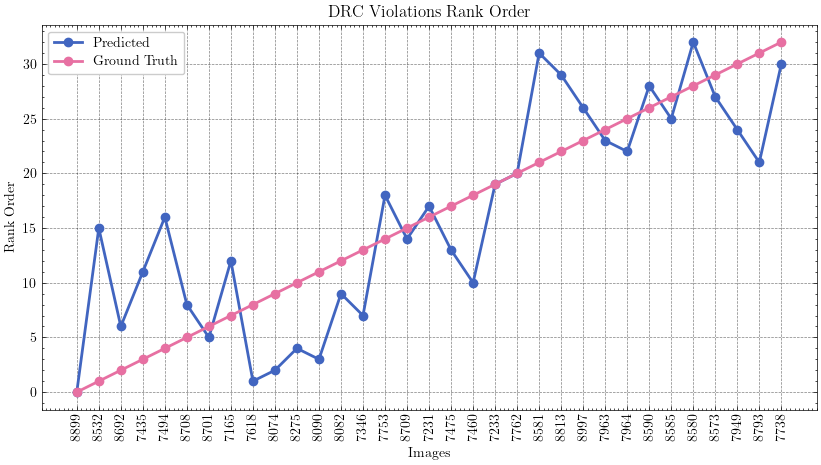

In [423]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.6850761440149947), pvalue=np.float64(1.5477120842377092e-49)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7080090777677354), pvalue=np.float64(3.239769997630009e-54)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5140822326373949), pvalue=np.float64(1.8151289853670888e-46))}

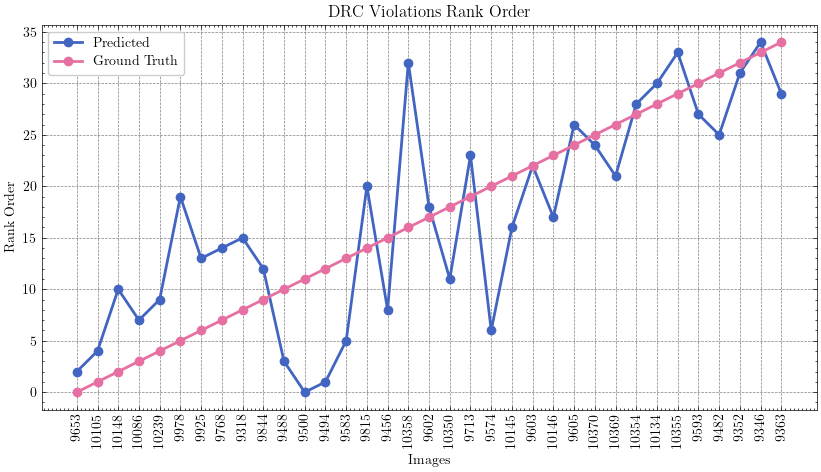

In [426]:
evaluate_design(test_df_b)

Text(0, 0.5, 'Feature')

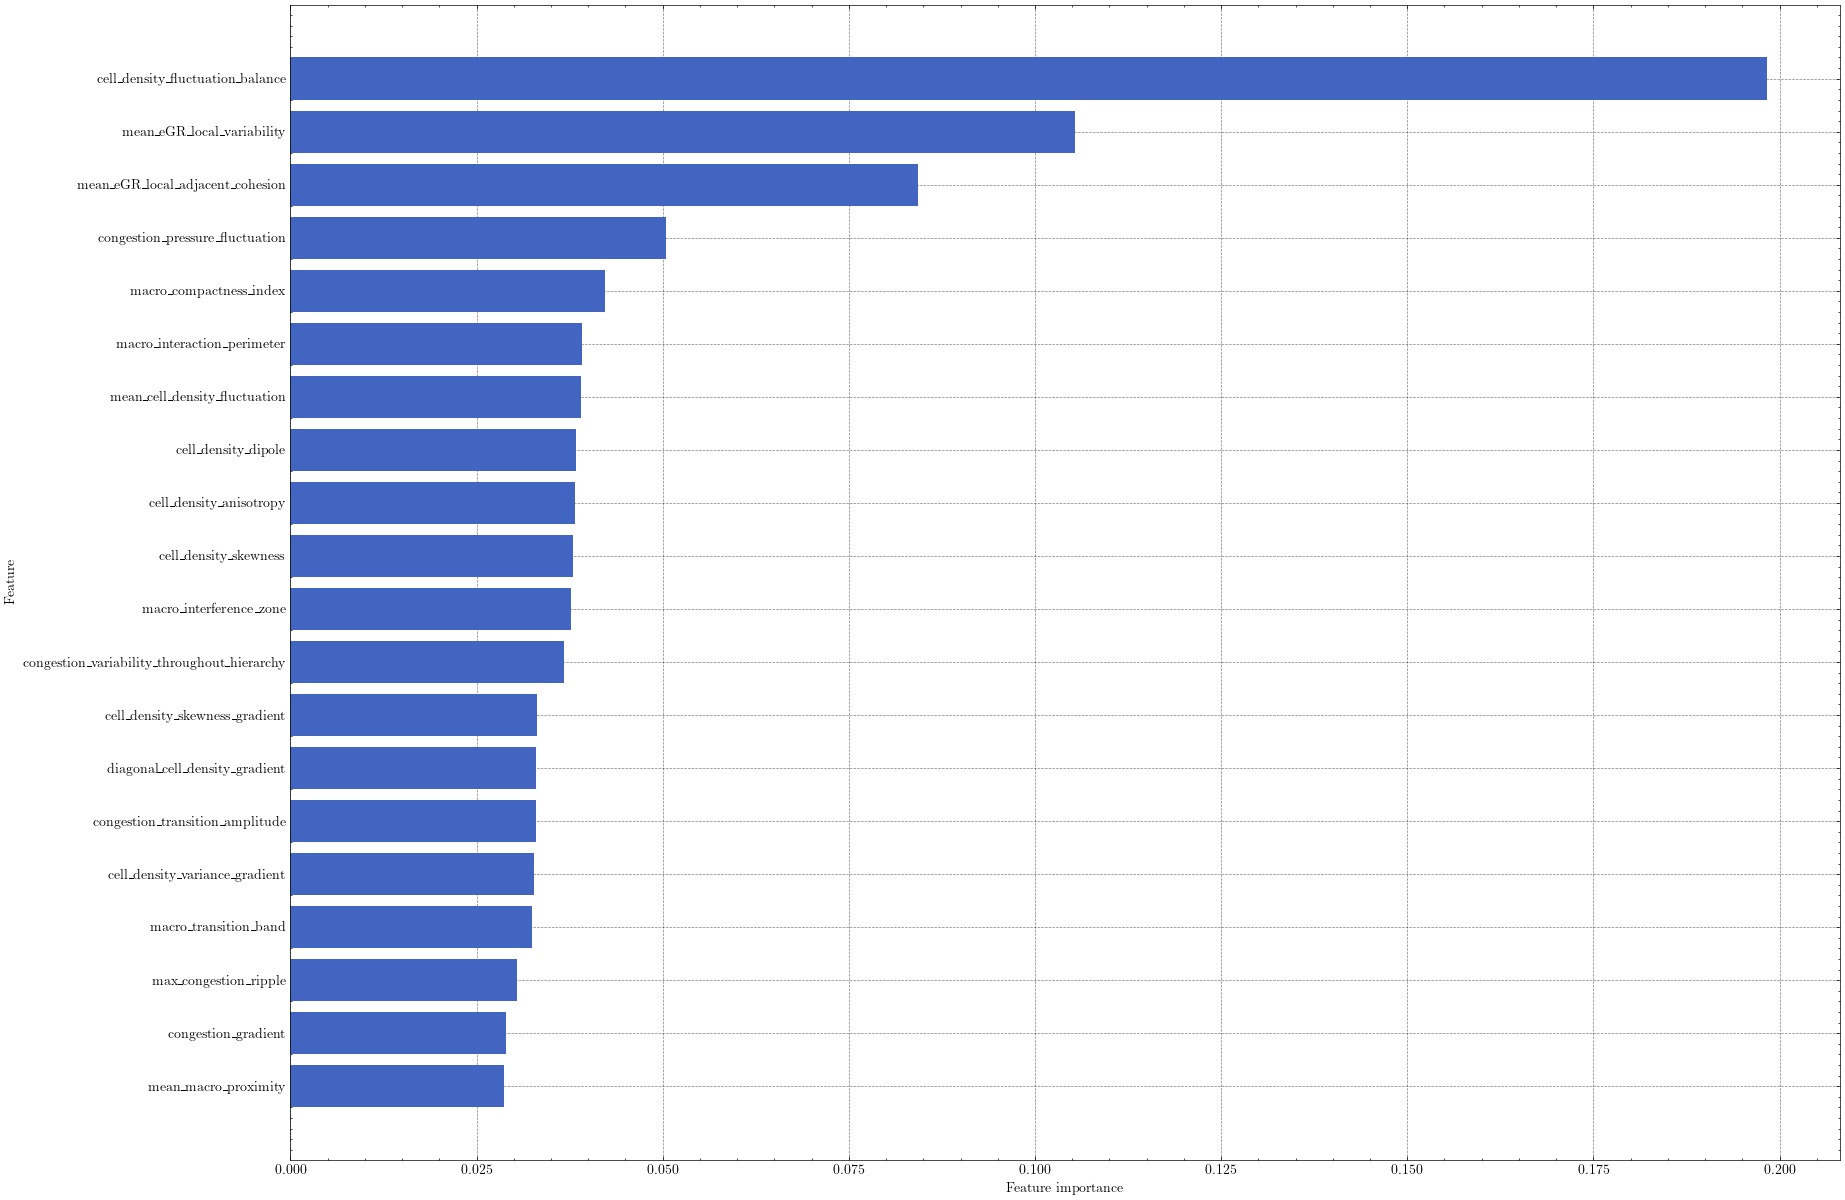

In [429]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [427]:
feat_pool

{'max_congestion_ripple': 'the maximum observed propagation of congestion from a source point',
 'congestion_gradient': 'the rate of change in congestion levels across the layout, highlighting potential bottleneck areas',
 'mean_macro_proximity': 'the average distance between macros and nearby elements, indicating potential congestion zones',
 'diagonal_cell_density_gradient': 'the rate of change in cell density along the diagonals of the layout, indicating unique transition areas that may impact diagonal routing paths',
 'mean_cell_density_fluctuation': 'the average fluctuation of cell density in specific regions of the layout, highlighting potential areas of instability impacting routing paths and DRC violations',
 'congestion_transition_amplitude': 'the magnitude of change in congestion levels between adjacent regions, highlighting areas with significant transitions that could lead to potential routing bottlenecks or DRC violations.',
 'cell_density_variance_gradient': 'the variatio

In [428]:
feat_func_list

[<function __main__.max_congestion_ripple(images)>,
 <function __main__.macro_interference_zone(images)>,
 <function __main__.macro_compactness_index(images)>,
 <function __main__.cell_density_variance_gradient(images)>,
 <function __main__.mean_macro_proximity(images)>,
 <function __main__.congestion_gradient(images)>,
 <function __main__.cell_density_anisotropy(images)>,
 <function __main__.mean_eGR_local_variability(images)>,
 <function __main__.diagonal_cell_density_gradient(images)>,
 <function __main__.mean_cell_density_fluctuation(images)>,
 <function __main__.macro_transition_band(images)>,
 <function __main__.cell_density_skewness(images)>,
 <function __main__.cell_density_skewness_gradient(images)>,
 <function __main__.macro_interaction_perimeter(images)>,
 <function __main__.cell_density_fluctuation_balance(images)>,
 <function __main__.congestion_pressure_fluctuation(images)>,
 <function __main__.congestion_variability_throughout_hierarchy(images)>,
 <function __main__.cong